In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Path to the .rar file
rar_file_path = "/content/drive/MyDrive/Original_Data_Only_Augmented_10000.rar"

# Destination folder for extracted files
extract_to = "/content/myData"

# Ensure the destination directory exists
os.makedirs(extract_to, exist_ok=True)

# Extract using unrar
!unrar x -r {rar_file_path} {extract_to}

Streaming output truncated to the last 5000 lines.
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_N030_slice_4_NoInf_NoReflowN_randAug37_randAug3907.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_N041_slice_2_NoInf_NoReflowN.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_N012_slice_8_NoInf_NoReflowN.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_N049_slice_5_NoInf_NoReflowN_randAug84_randAug1359.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_P098_slice_5_Inf_NoReflowN_aug_4864.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_P005_slice_6_Inf_NoReflowY_randAug1724_aug_1650.npy      51%  OK 
Extracting  /content/myData/final_data/images/train/EMIDEC_Case_N084_slice_6_NoInf_NoReflowN_aug_1129.npy      51%  OK 
Extracting  /content/myData/fi

In [ ]:
# Paths to the images and masks directories
test_images_path = "/content/myData/final_data/images/test"
test_masks_path = "/content/myData/final_data/masks/test"

# List and sort files to ensure they match
test_image_files = sorted(os.listdir(test_images_path))
test_mask_files = sorted(os.listdir(test_masks_path))

In [ ]:
def load_dataset(images_path, masks_path):
    images = []
    masks = []
    filenames = []

    # List all files in sorted order to ensure proper alignment
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    for img_file, mask_file in zip(image_files, mask_files):
        # Full paths
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Load images and masks as NumPy arrays
        img = np.load(img_path)  # Shape: (H, W) or (H, W, C)
        mask = np.load(mask_path)  # Shape: (H, W) or (H, W, C)

        # Append to lists
        images.append(img)
        masks.append(mask)
        filenames.append(img_file)

    return images, masks, filenames

In [ ]:
# Load dataset
test_images_tensor, test_masks_tensor, test_filenames = load_dataset(test_images_path, test_masks_path)
test_images_tensor = tf.expand_dims(test_images_tensor, axis=-1)
test_masks_tensor = tf.expand_dims(test_masks_tensor, axis=-1)


# Check shapes
print(f"Test Images Tensor Shape: {test_images_tensor.shape}, dtype: {test_images_tensor.dtype}")
print(f"Test Masks Tensor Shape: {test_masks_tensor.shape}, dtype: {test_masks_tensor.dtype}")

Test Images Tensor Shape: (80, 128, 128, 1), dtype: <dtype: 'float64'>
Test Masks Tensor Shape: (80, 128, 128, 1), dtype: <dtype: 'float64'>


In [ ]:
# Model input shape
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = test_images_tensor.shape[1:]
NUM_CLASSES = 5
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
batch_size = 8

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, MeanIoU
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [ ]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)


    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [ ]:
def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Flatten tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

        # Cast to int32 before using one-hot
        y_true_flat = tf.cast(y_true_flat, tf.int32)

        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(y_true_flat, depth=tf.shape(y_pred)[-1])

        # Standard categorical crossentropy
        ce = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred_flat)

        # Apply per-pixel weights based on true class
        weights = tf.gather(class_weights, y_true_flat)
        weighted_loss = ce * weights

        return tf.reduce_mean(weighted_loss)

    return loss


In [ ]:
# Class weights as per generator loss
class_weights = tf.constant([1.0, 7.0, 11.0, 26.0, 90.0], dtype=tf.float32)

model = Attention_ResUNet(input_shape=(128, 128, 1), NUM_CLASSES=5)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=weighted_sparse_categorical_crossentropy(class_weights),
    metrics=[SparseCategoricalAccuracy()]
)
model.summary()

Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 128, 128,  │        128 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_62[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 128, 128,  │          0 │ add_26[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ activation_63[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 64, 64,    │      8,320 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 64, 64,    │    147,584 │ activation_64[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_101[0][0]

 Total params: 39,089,373 (149.11 MB)

 Trainable params: 39,067,859 (149.03 MB)

 Non-trainable params: 21,514 (84.04 KB)

In [ ]:
model.load_weights('/content/drive/MyDrive/Original_Data_Only_Augmented_10000/ckpt/ckpt-epoch40.weights.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Predict class logits
preds = model.predict(test_images_tensor, batch_size=8)

# Convert logits to class labels
pred_labels = tf.argmax(preds, axis=-1)  # shape: (80, 128, 128)

# Ground truth labels
true_labels = tf.squeeze(test_masks_tensor, axis=-1)  # shape: (80, 128, 128)


10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step


In [ ]:
def dice_score(y_true, y_pred, class_id, smooth=1e-6):
    y_true_cls = tf.cast(tf.equal(y_true, class_id), tf.float32)
    y_pred_cls = tf.cast(tf.equal(y_pred, class_id), tf.float32)

    intersection = tf.reduce_sum(y_true_cls * y_pred_cls)
    union = tf.reduce_sum(y_true_cls) + tf.reduce_sum(y_pred_cls)

    return (2. * intersection + smooth) / (union + smooth)

# Per-class dice scores
num_classes = 5
dice_scores = []
for class_id in range(num_classes):
    dice = dice_score(true_labels, pred_labels, class_id)
    dice_scores.append(dice)
    print(f"Dice score for class {class_id}: {dice:.4f}")

# Total average dice
avg_dice = tf.reduce_mean(dice_scores)
print(f"\nTotal average Dice score: {avg_dice:.4f}")


Dice score for class 0: 0.9891
Dice score for class 1: 0.9350
Dice score for class 2: 0.8222
Dice score for class 3: 0.6126
Dice score for class 4: 0.5376

Total average Dice score: 0.7793


In [ ]:
# Convert tensors to numpy arrays
true_np = true_labels.numpy()
pred_np = pred_labels.numpy()

def detection_accuracy(class_id):
    correct = 0
    total = 0
    for t, p in zip(true_np, pred_np):
        has_class_true = np.any(t == class_id)
        has_class_pred = np.any(p == class_id)
        if has_class_true == has_class_pred:
            correct += 1
        total += 1
    return correct / total

infarction_acc = detection_accuracy(3)
noreflow_acc = detection_accuracy(4)

print(f"\nDetection accuracy:")
print(f"Infarction (class 3): {infarction_acc:.4f}")
print(f"No-reflow (class 4): {noreflow_acc:.4f}")



Detection accuracy:
Infarction (class 3): 0.8625
No-reflow (class 4): 0.8500


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
def generate_images(model, test_input, tar):
    test_input = tf.squeeze(test_input, axis=0)  # Remove batch dim
    tar = tf.squeeze(tar, axis=0)  # Remove batch dim
    prediction = model(tf.expand_dims(test_input, axis=0), training=False)
    prediction = tf.argmax(prediction, axis=-1)  # Convert softmax to class labels
    prediction = tf.squeeze(prediction, axis=0)  # Remove batch dim

    cmap_mask = ListedColormap(['black', 'white', 'gray', 'red', 'yellow'])

    plt.figure(figsize=(15, 5))
    display_list = [test_input, tar, prediction]
    titles = ['Input Image', 'Ground Truth Mask', 'Predicted Mask']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])

        if i == 0:
            # Assume grayscale input
            if len(display_list[i].shape) == 2:
                plt.imshow(display_list[i], cmap='gray')
            else:
                plt.imshow(tf.squeeze(display_list[i], axis=-1), cmap='gray')
        else:
            # Use colormap for masks
            plt.imshow(display_list[i], cmap=cmap_mask, vmin=0, vmax=4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()


  0%|          | 0/80 [00:00<?, ?it/s]

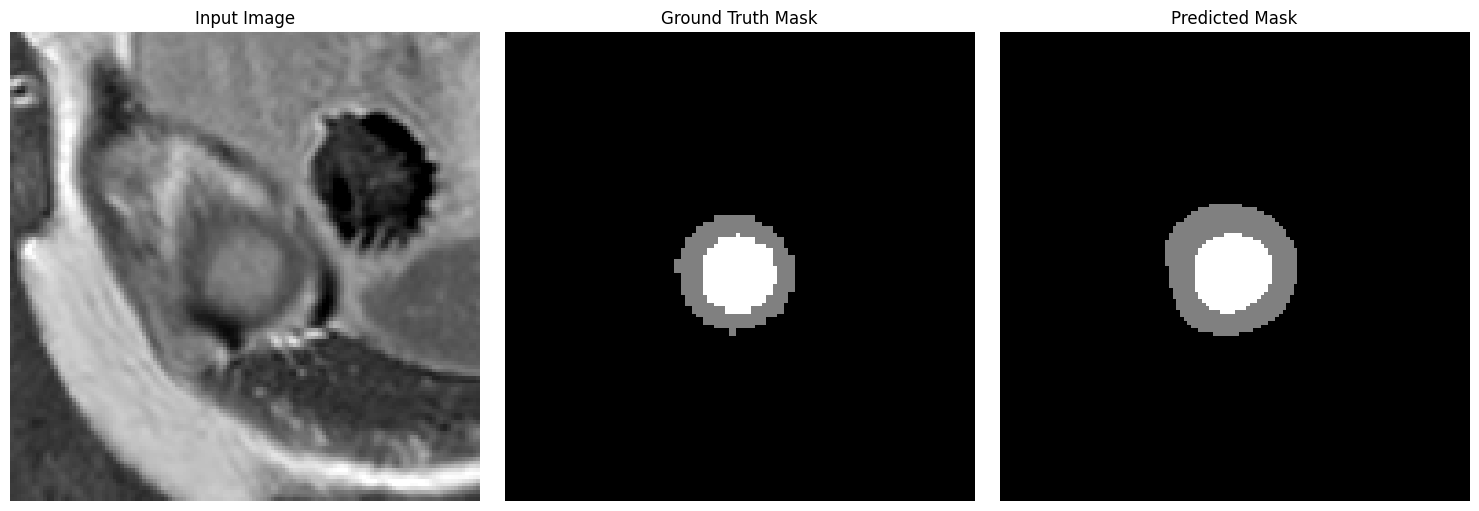

  1%|▏         | 1/80 [00:01<01:50,  1.40s/it]

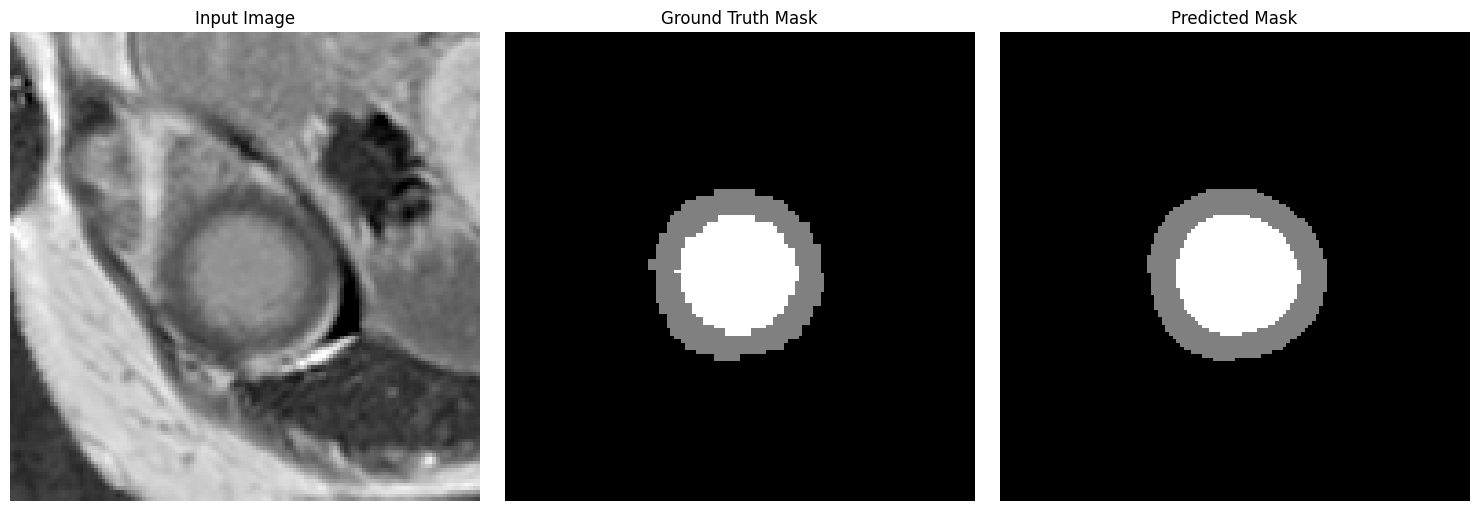

  2%|▎         | 2/80 [00:02<01:42,  1.31s/it]

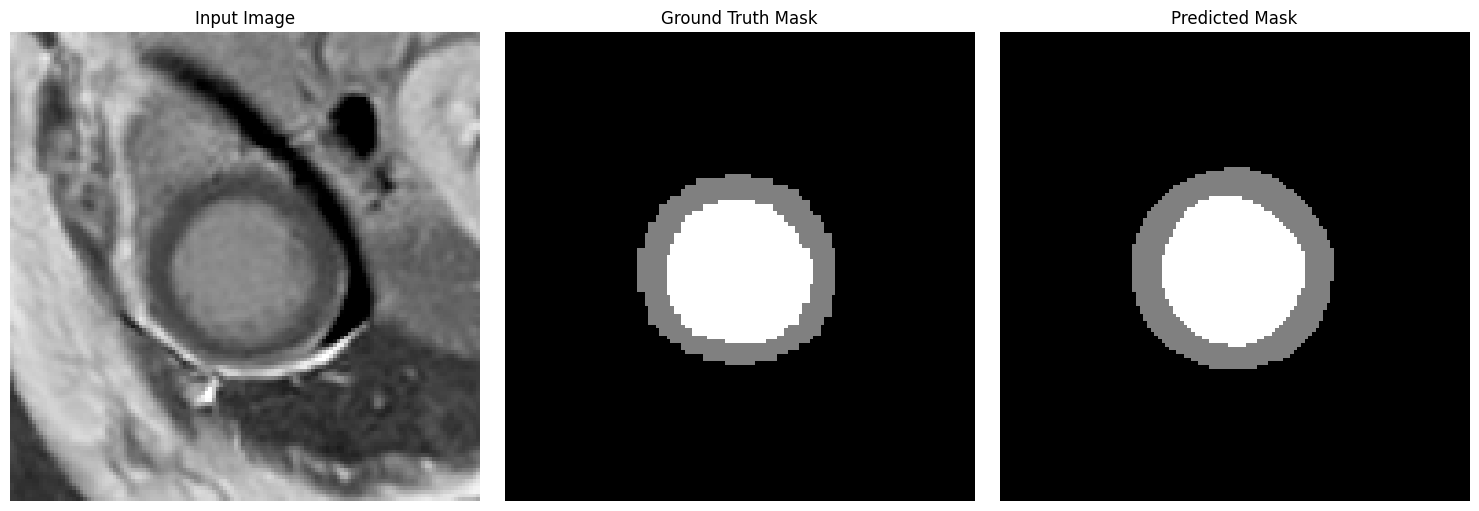

  4%|▍         | 3/80 [00:04<01:43,  1.35s/it]

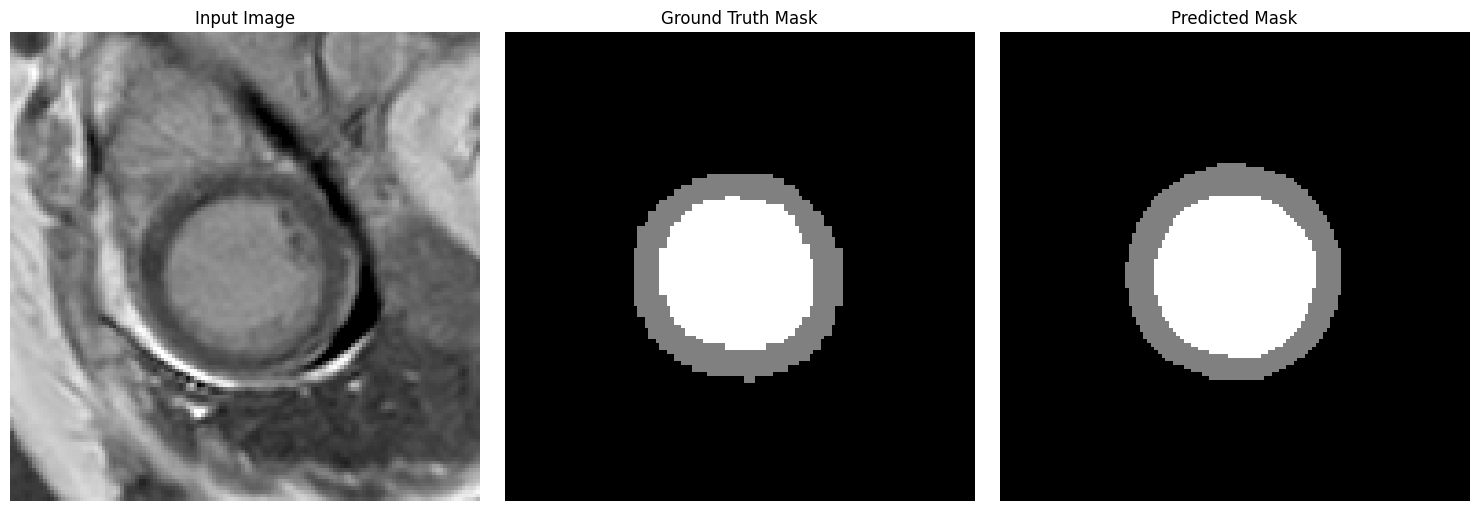

  5%|▌         | 4/80 [00:05<01:40,  1.32s/it]

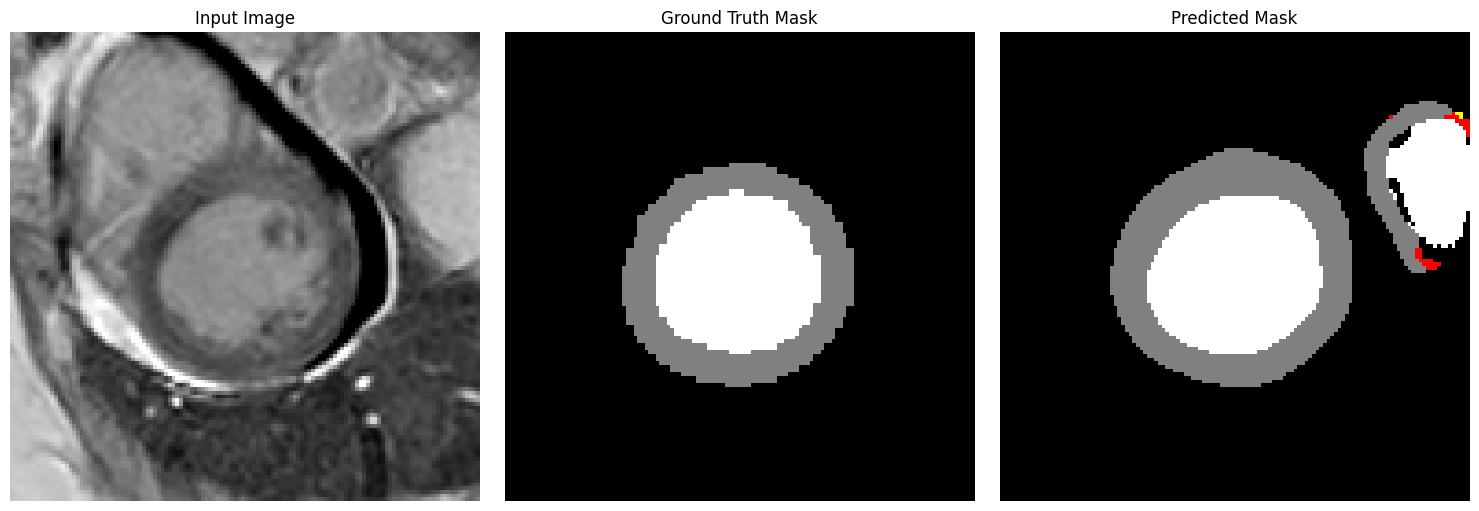

  6%|▋         | 5/80 [00:08<02:25,  1.93s/it]

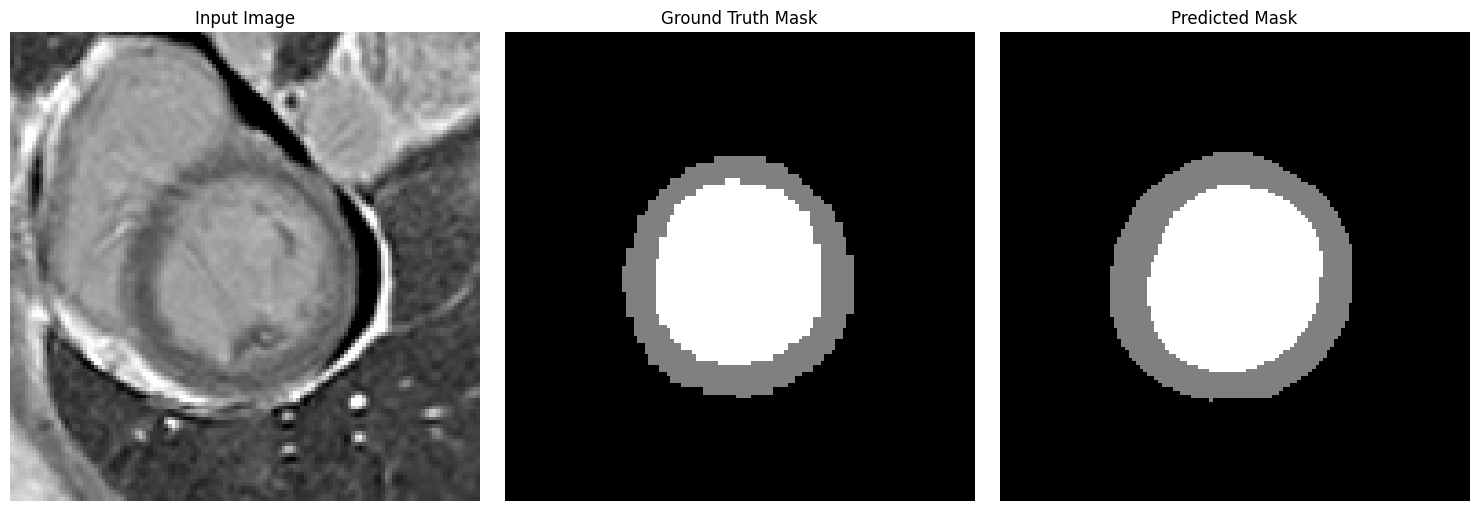

  8%|▊         | 6/80 [00:10<02:23,  1.94s/it]

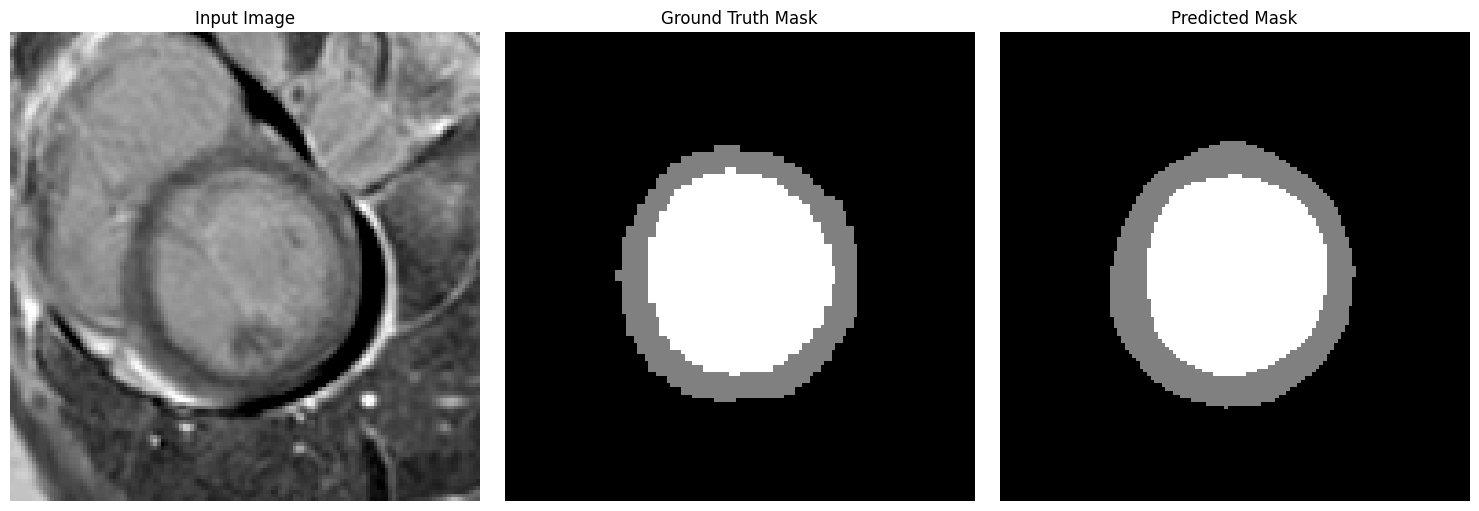

  9%|▉         | 7/80 [00:11<02:05,  1.72s/it]

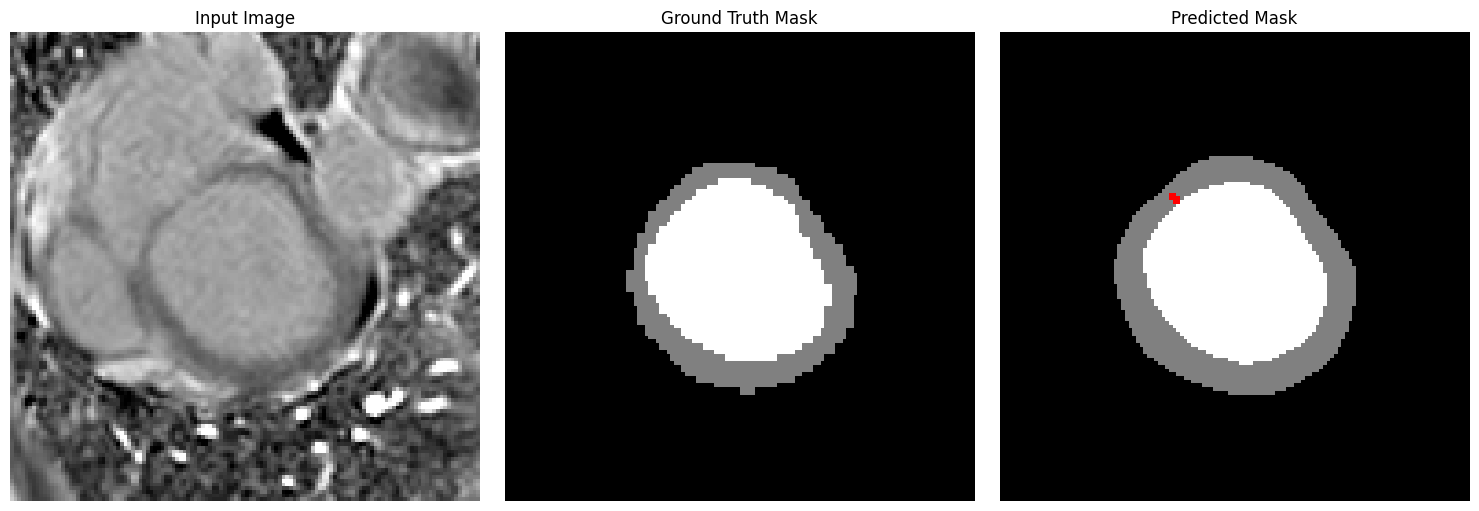

 10%|█         | 8/80 [00:12<01:53,  1.58s/it]

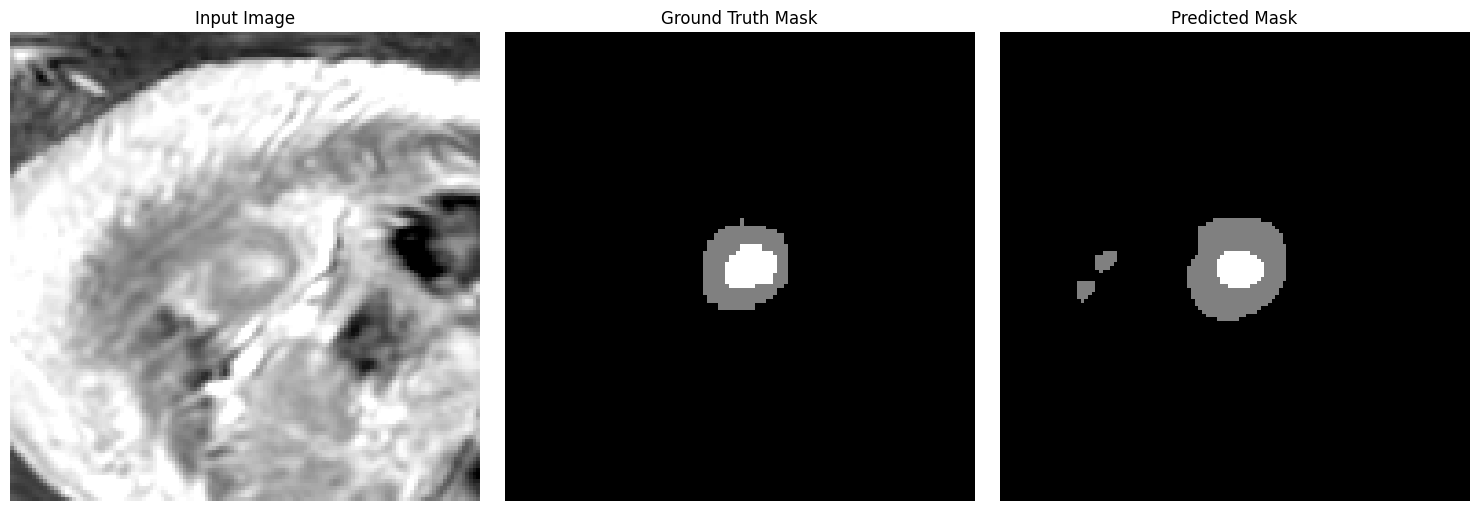

 11%|█▏        | 9/80 [00:14<01:46,  1.50s/it]

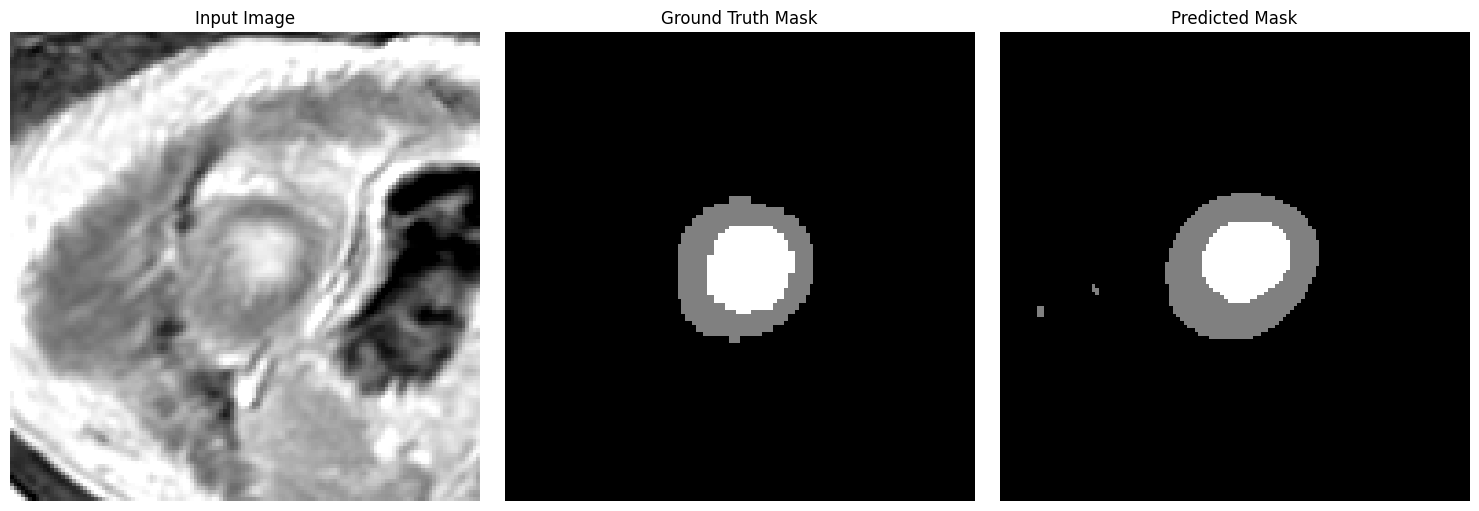

 12%|█▎        | 10/80 [00:15<01:40,  1.43s/it]

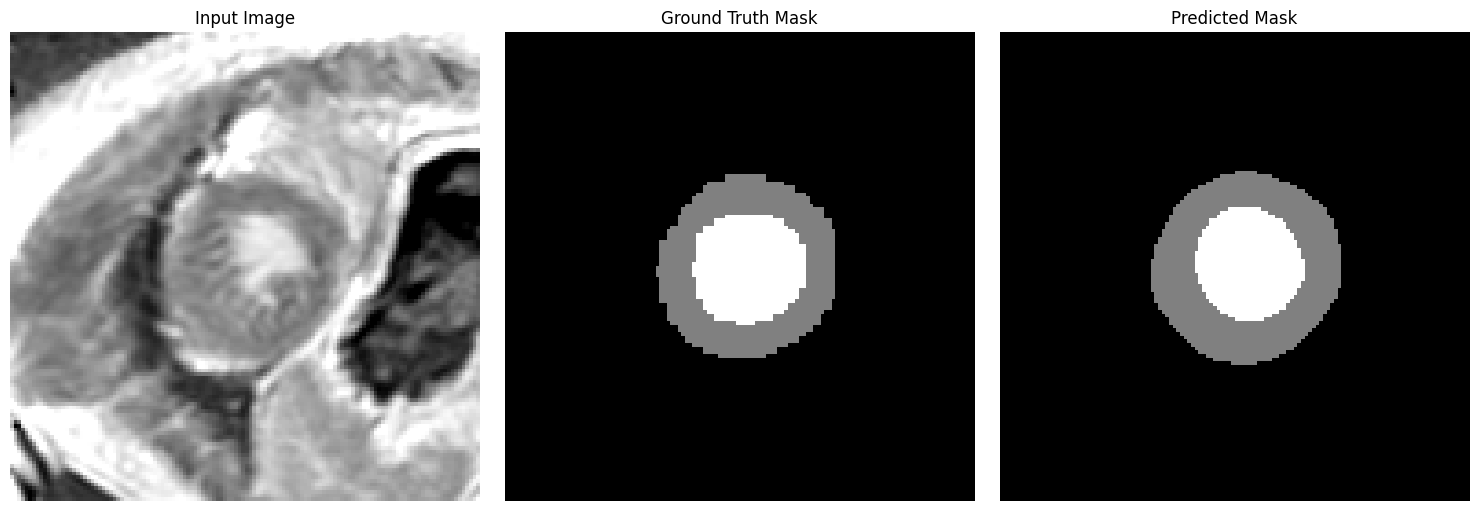

 14%|█▍        | 11/80 [00:16<01:37,  1.41s/it]

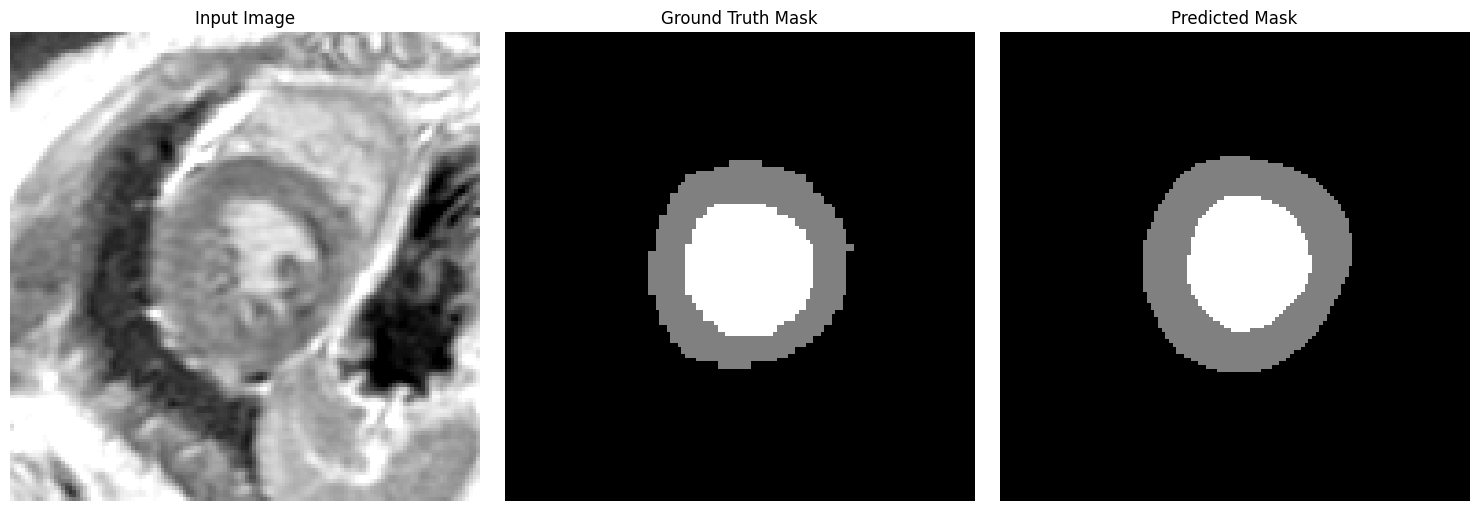

 15%|█▌        | 12/80 [00:18<01:32,  1.36s/it]

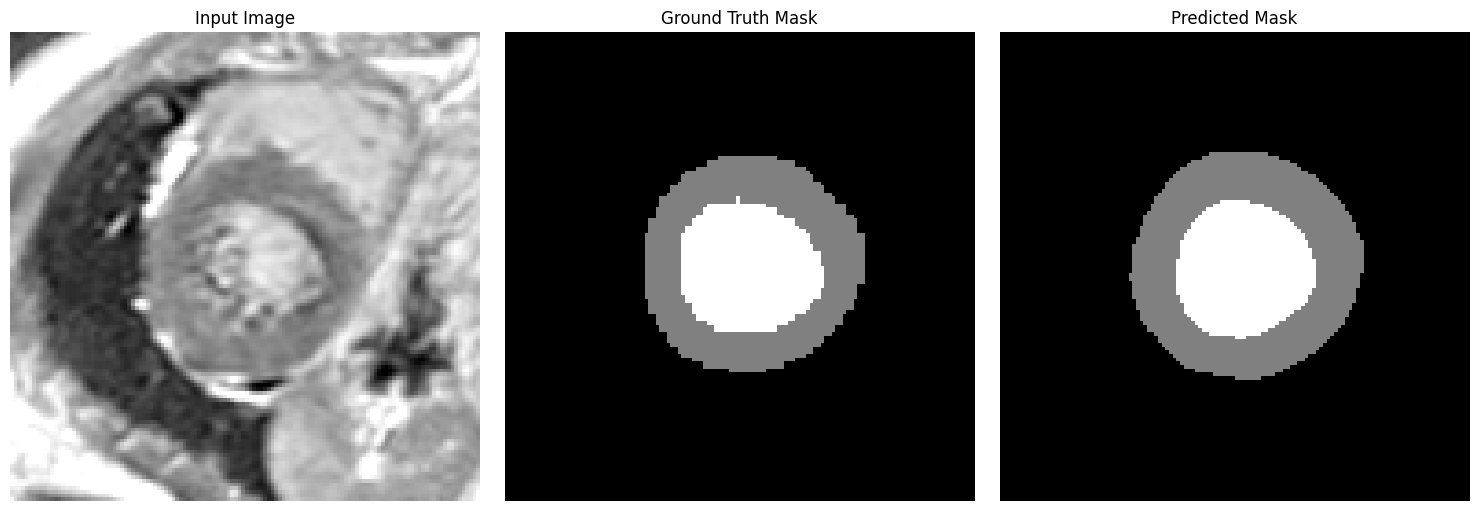

 16%|█▋        | 13/80 [00:19<01:30,  1.35s/it]

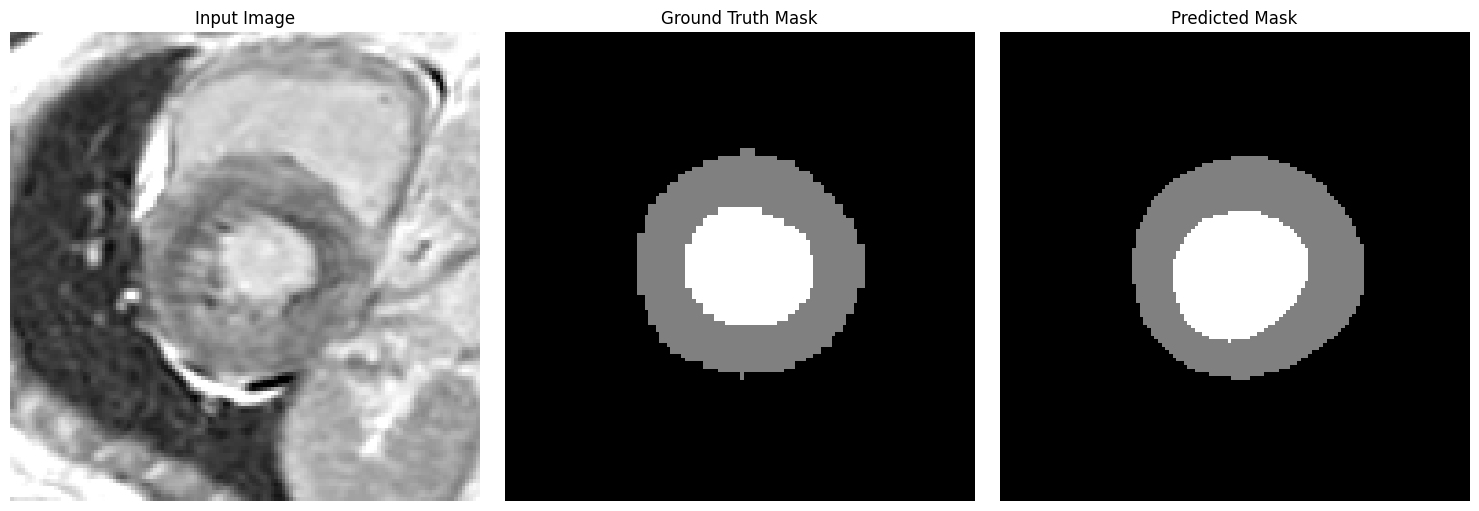

 18%|█▊        | 14/80 [00:21<01:38,  1.49s/it]

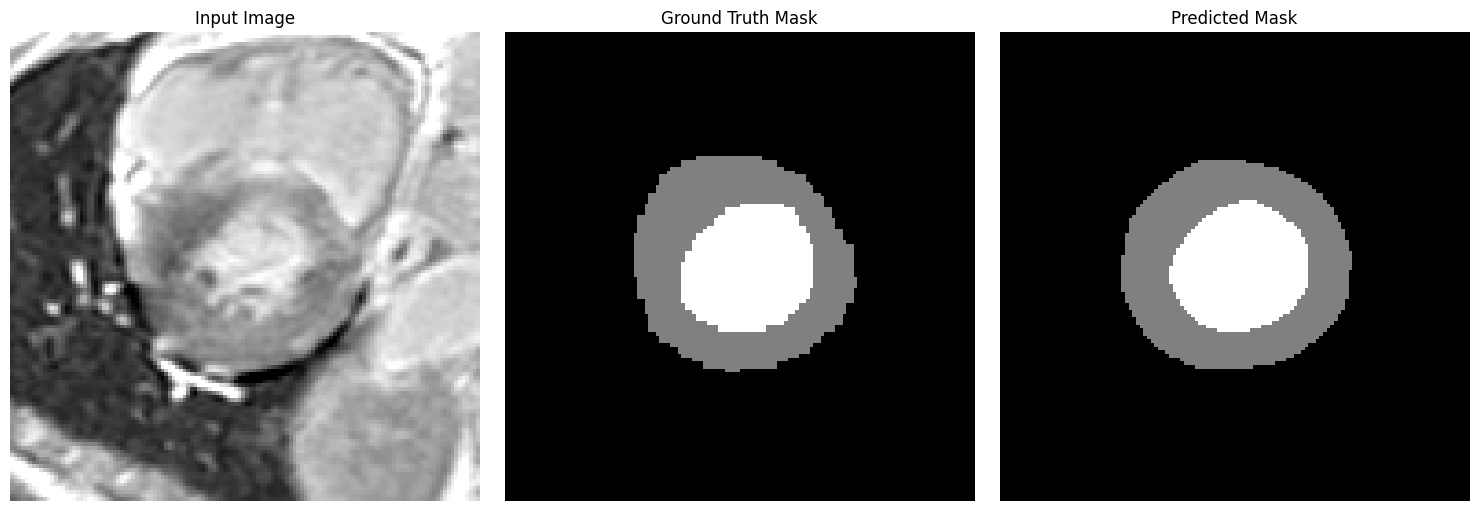

 19%|█▉        | 15/80 [00:23<01:49,  1.69s/it]

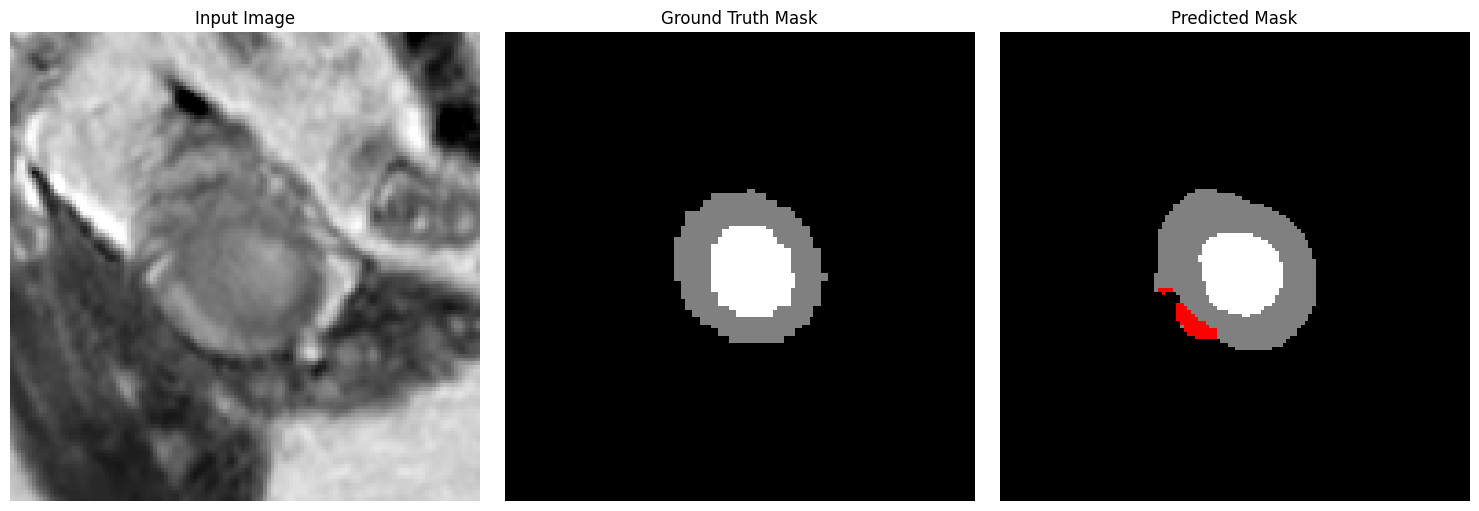

 20%|██        | 16/80 [00:25<01:48,  1.69s/it]

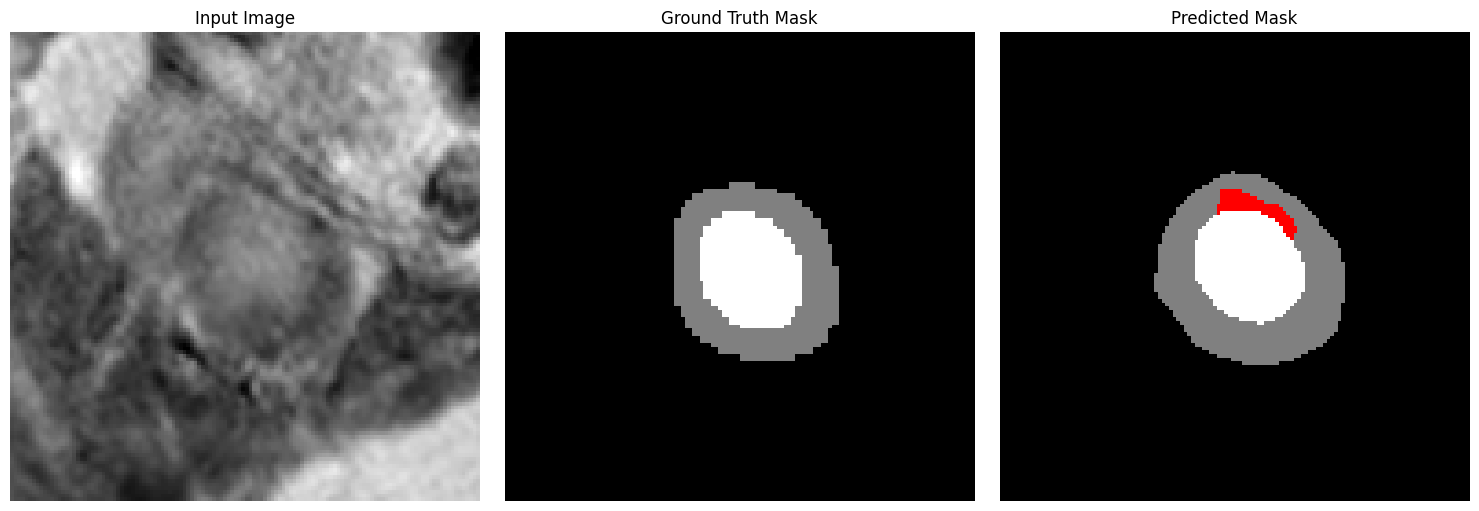

 21%|██▏       | 17/80 [00:26<01:38,  1.56s/it]

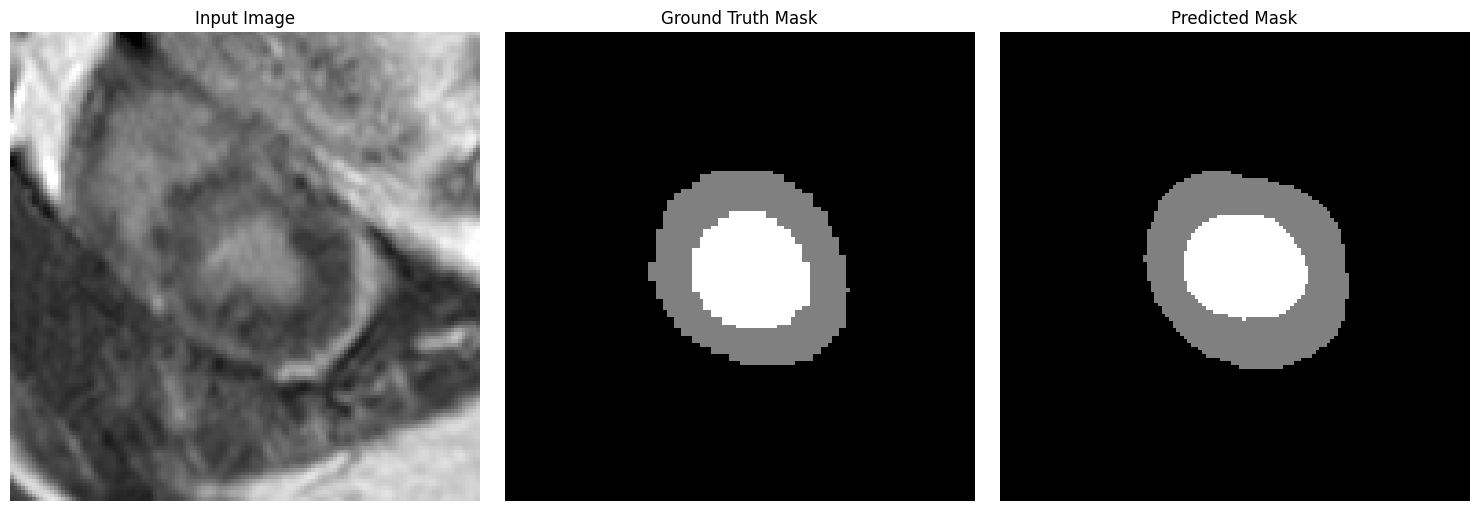

 22%|██▎       | 18/80 [00:27<01:31,  1.47s/it]

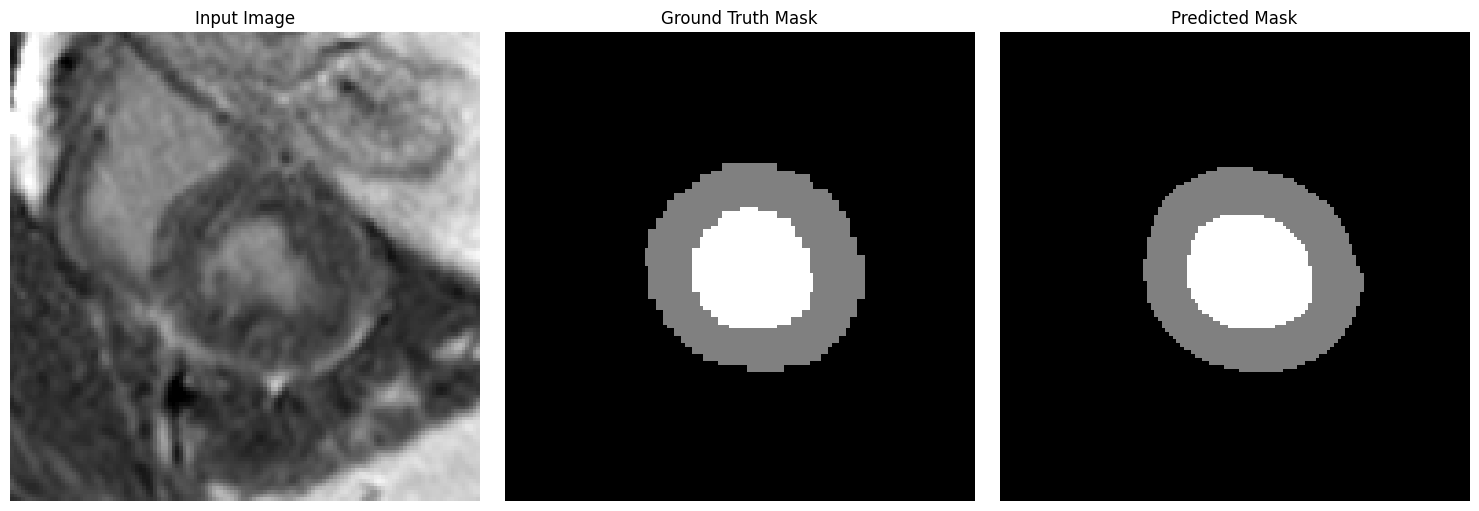

 24%|██▍       | 19/80 [00:28<01:28,  1.44s/it]

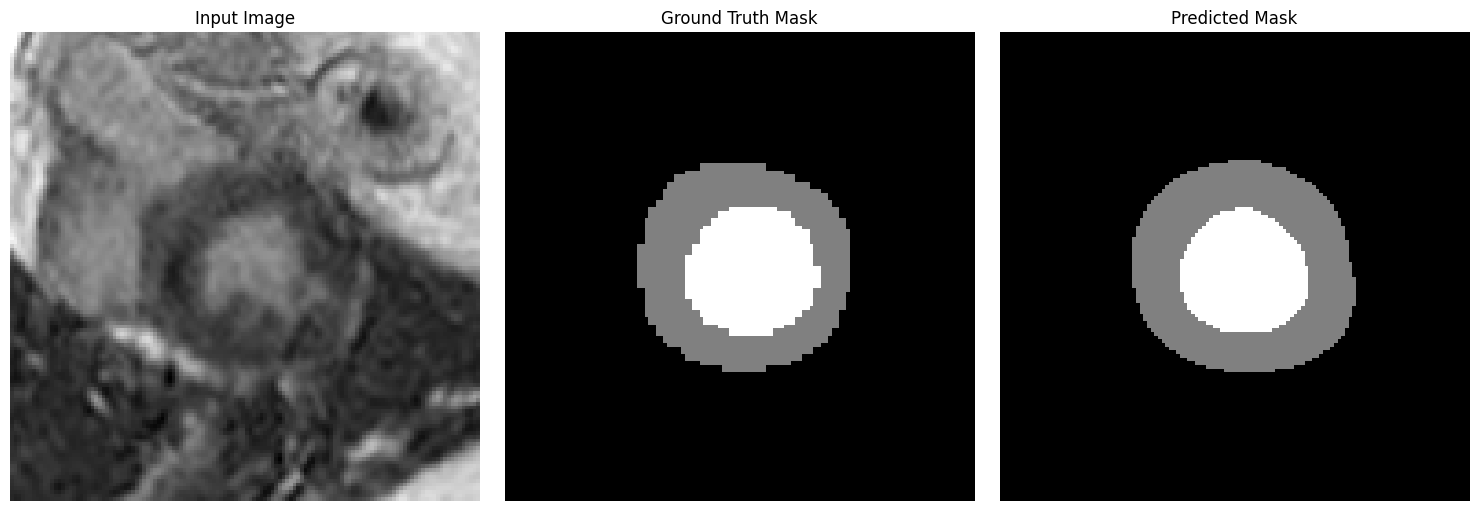

 25%|██▌       | 20/80 [00:30<01:23,  1.40s/it]

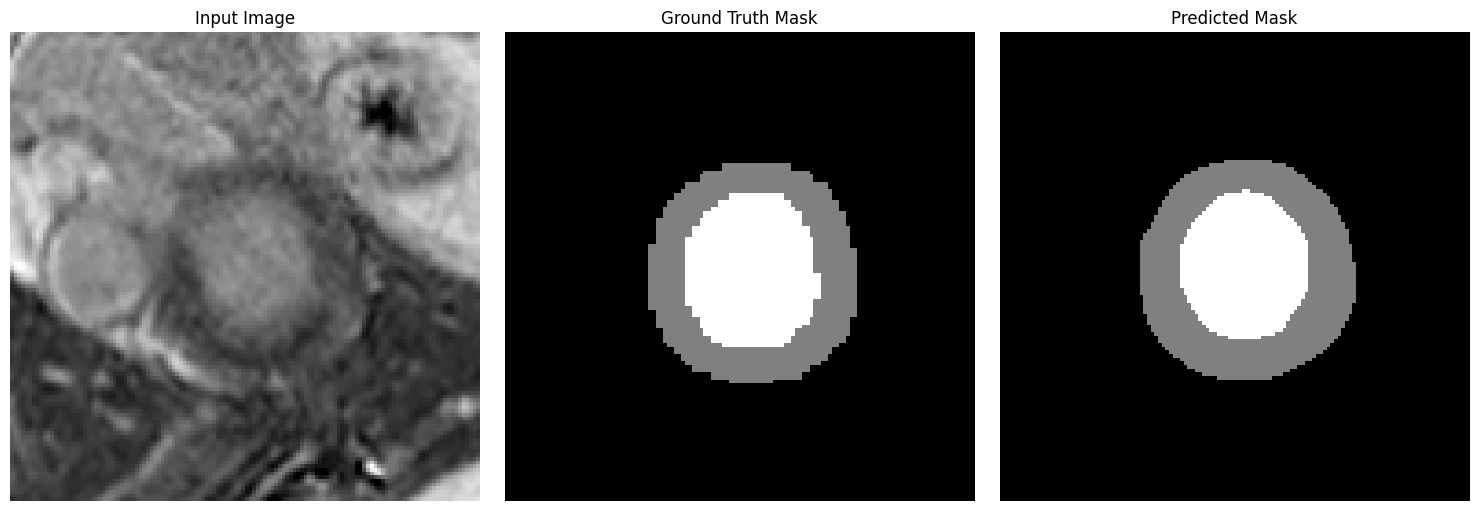

 26%|██▋       | 21/80 [00:31<01:20,  1.36s/it]

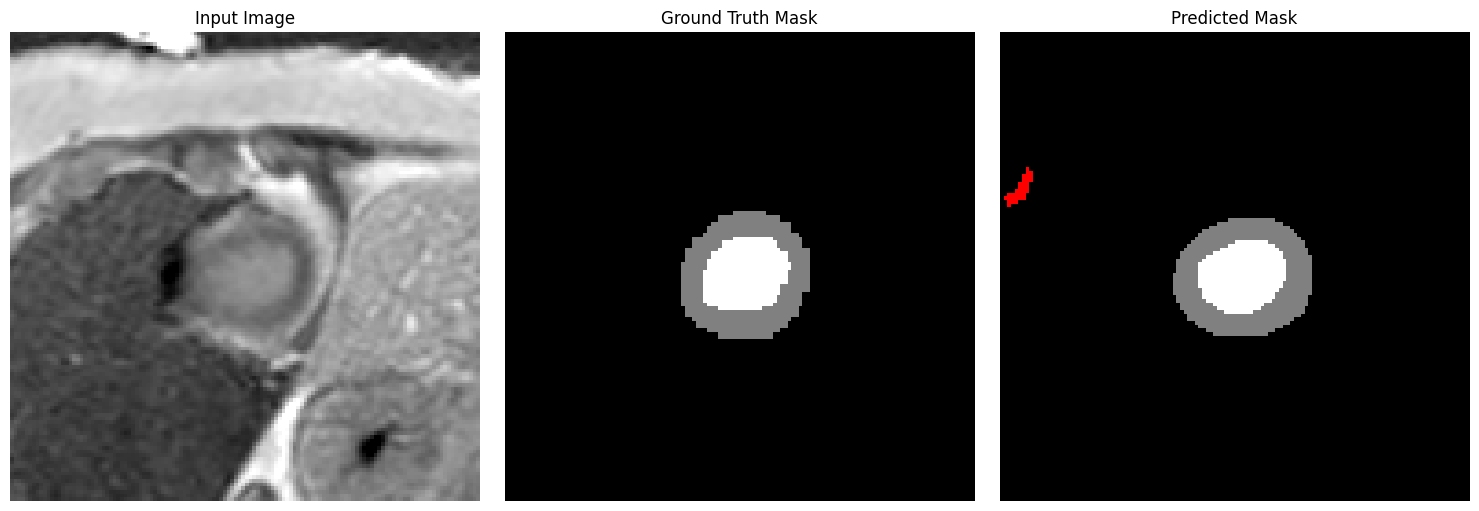

 28%|██▊       | 22/80 [00:32<01:16,  1.33s/it]

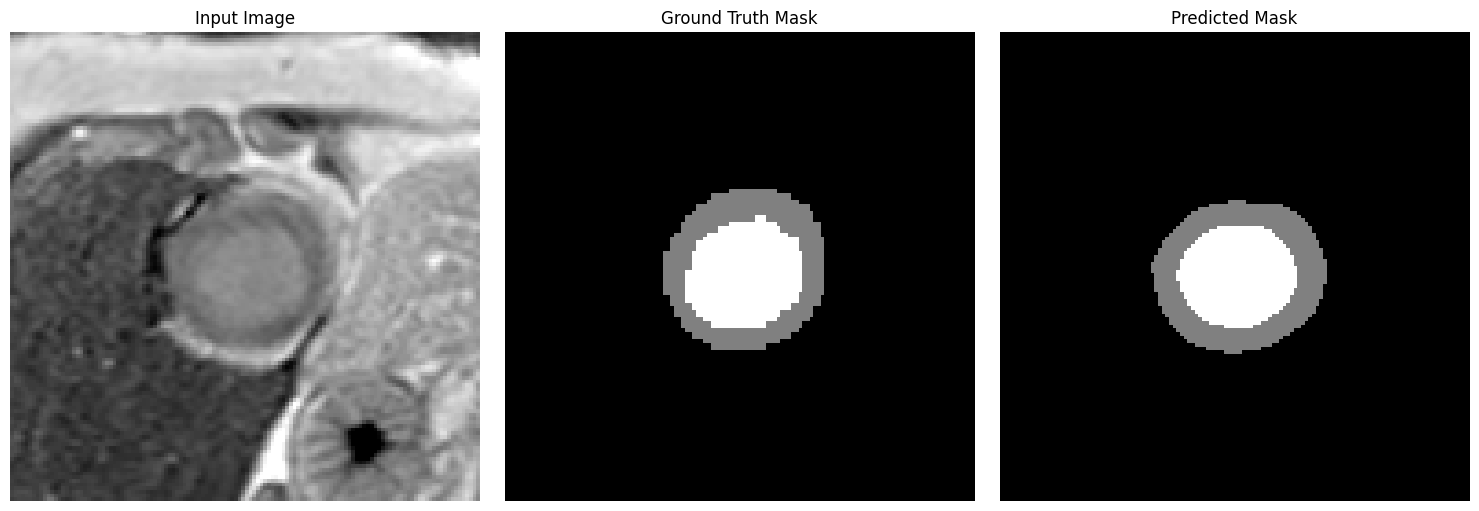

 29%|██▉       | 23/80 [00:34<01:15,  1.32s/it]

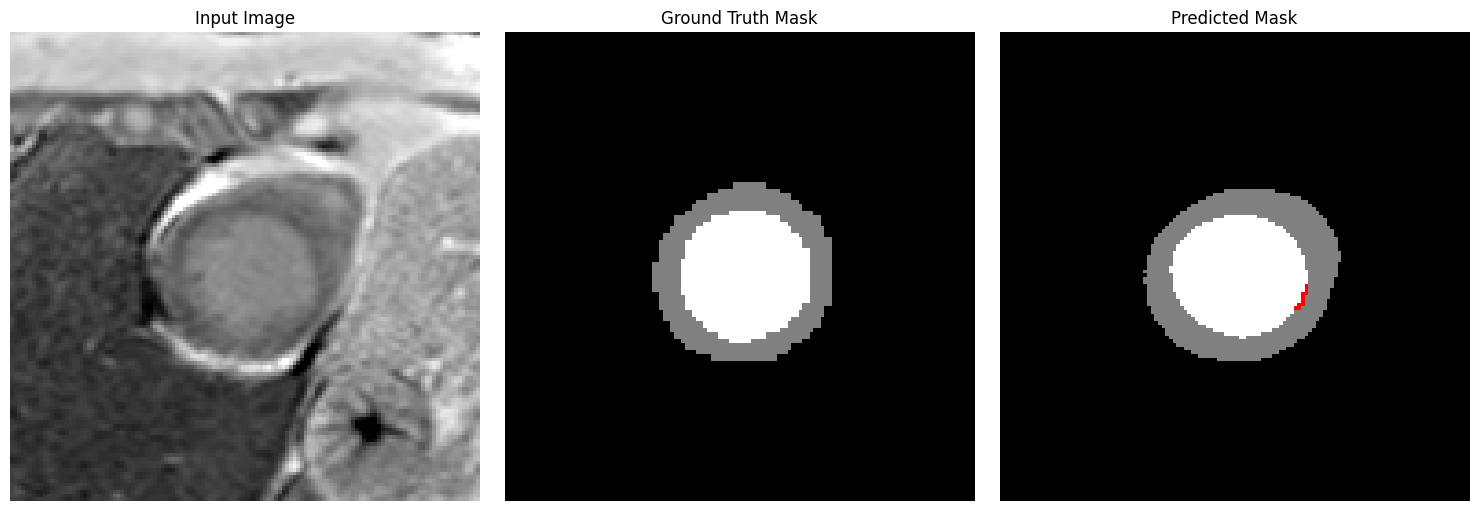

 30%|███       | 24/80 [00:36<01:26,  1.55s/it]

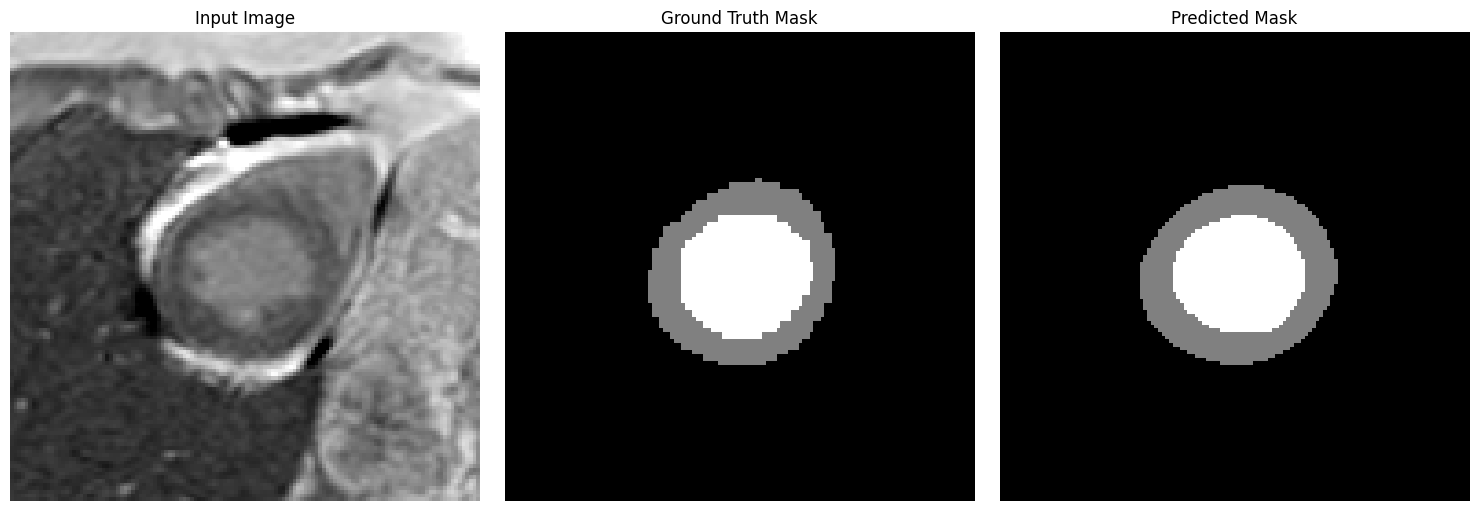

 31%|███▏      | 25/80 [00:38<01:46,  1.93s/it]

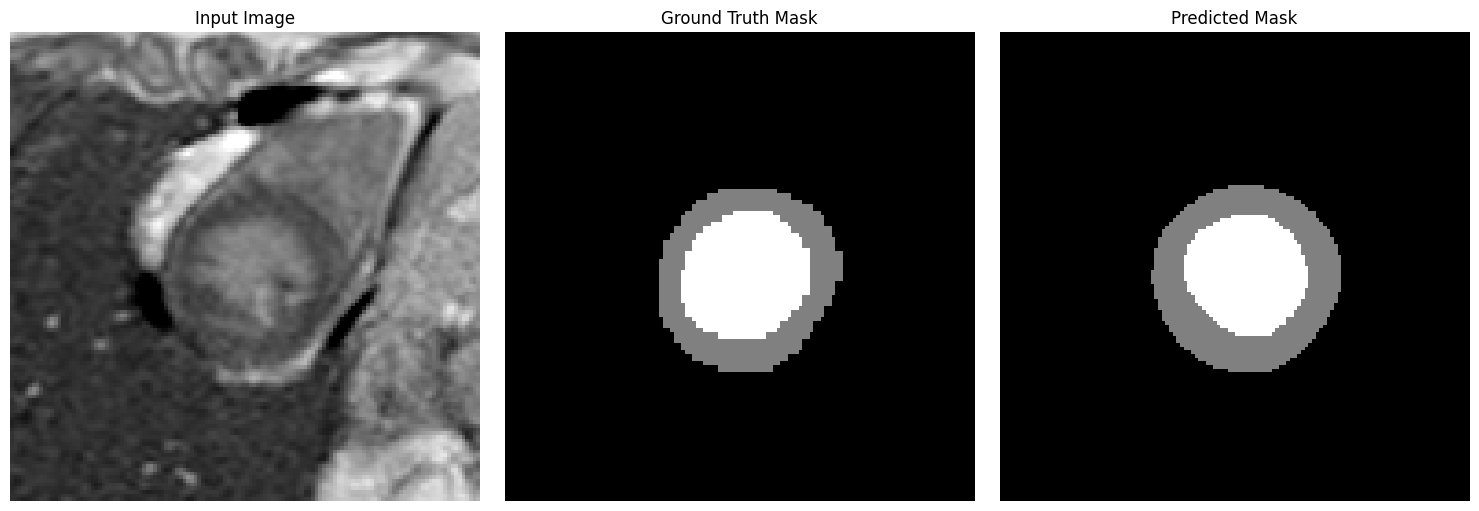

 32%|███▎      | 26/80 [00:40<01:33,  1.74s/it]

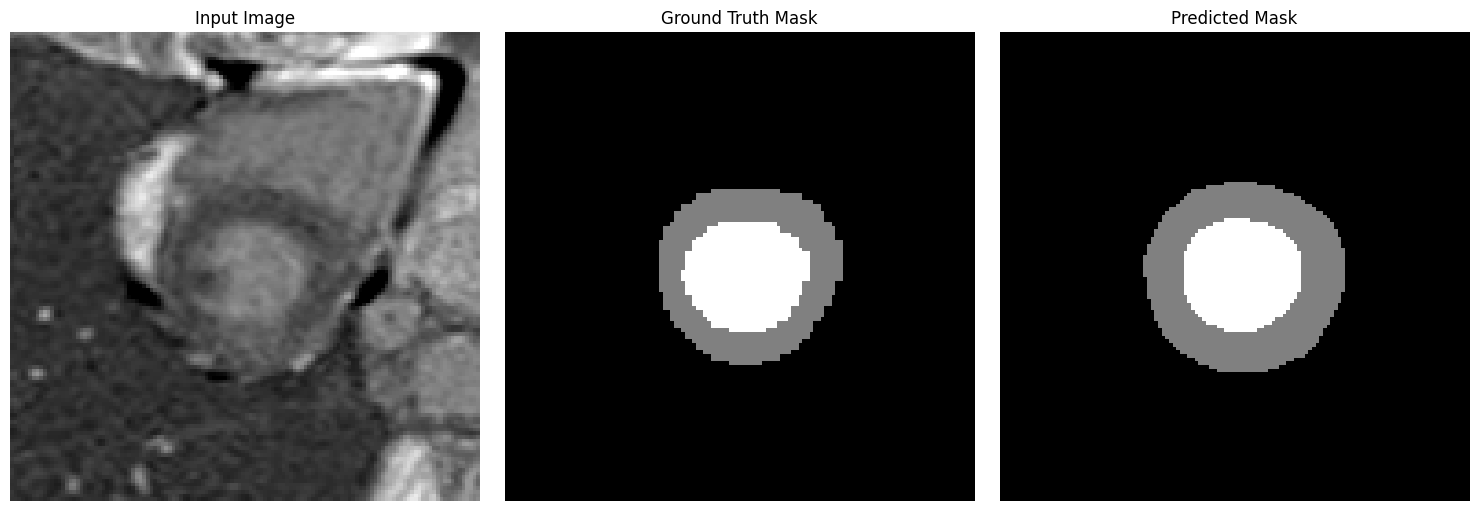

 34%|███▍      | 27/80 [00:41<01:24,  1.59s/it]

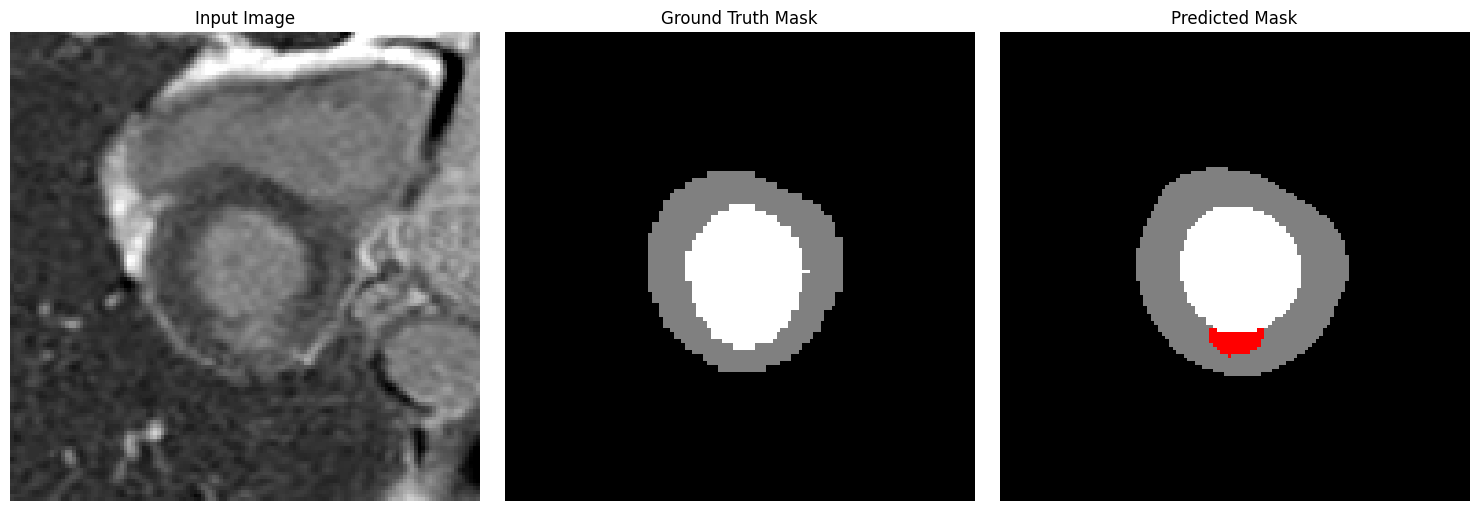

 35%|███▌      | 28/80 [00:42<01:18,  1.50s/it]

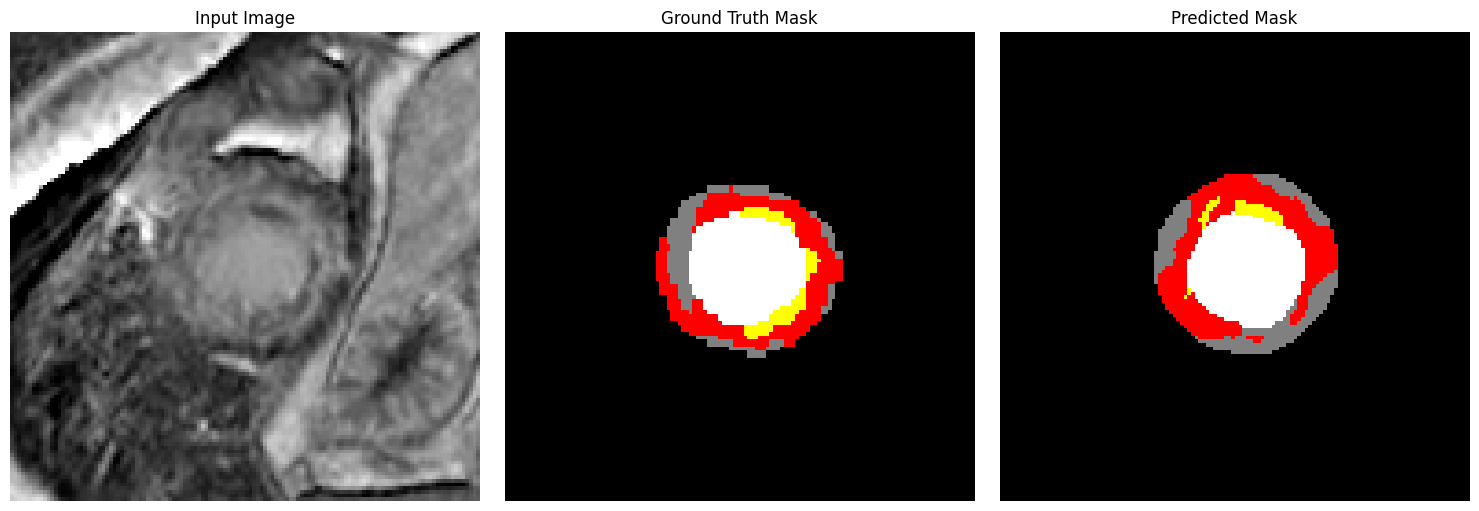

 36%|███▋      | 29/80 [00:44<01:15,  1.48s/it]

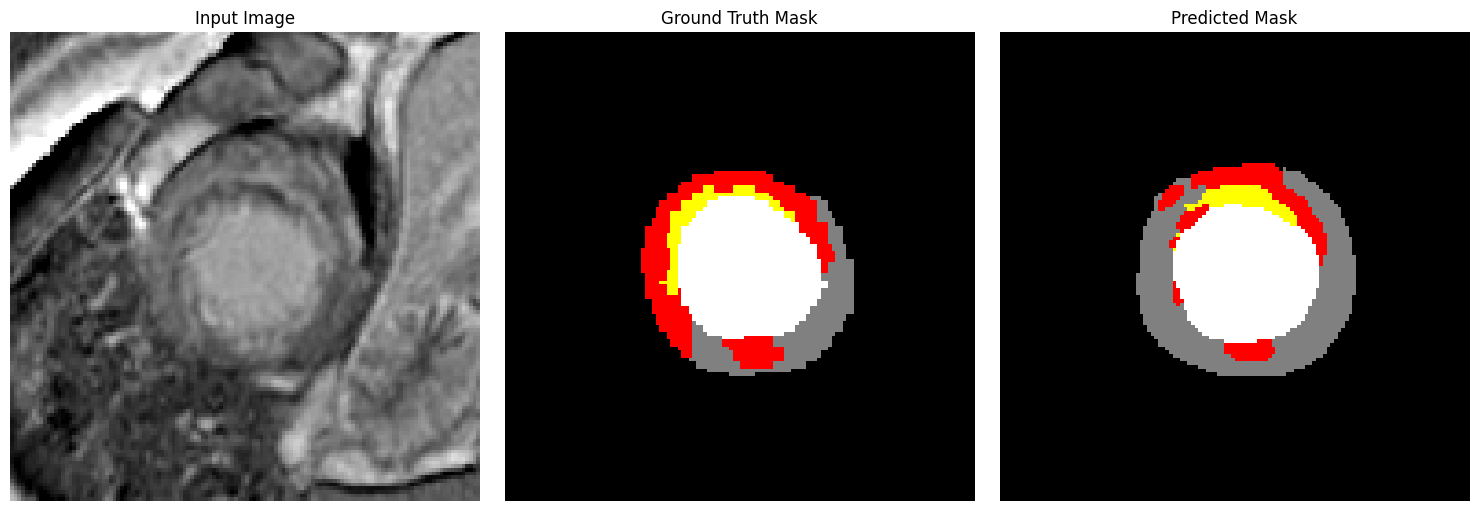

 38%|███▊      | 30/80 [00:45<01:12,  1.45s/it]

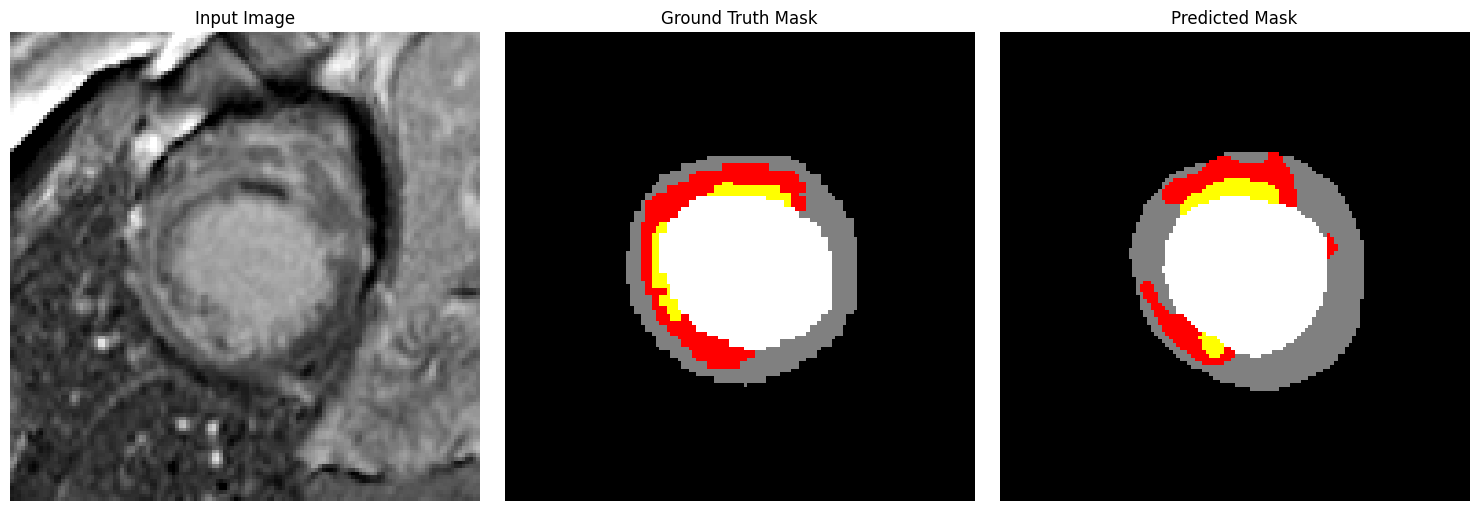

 39%|███▉      | 31/80 [00:46<01:09,  1.41s/it]

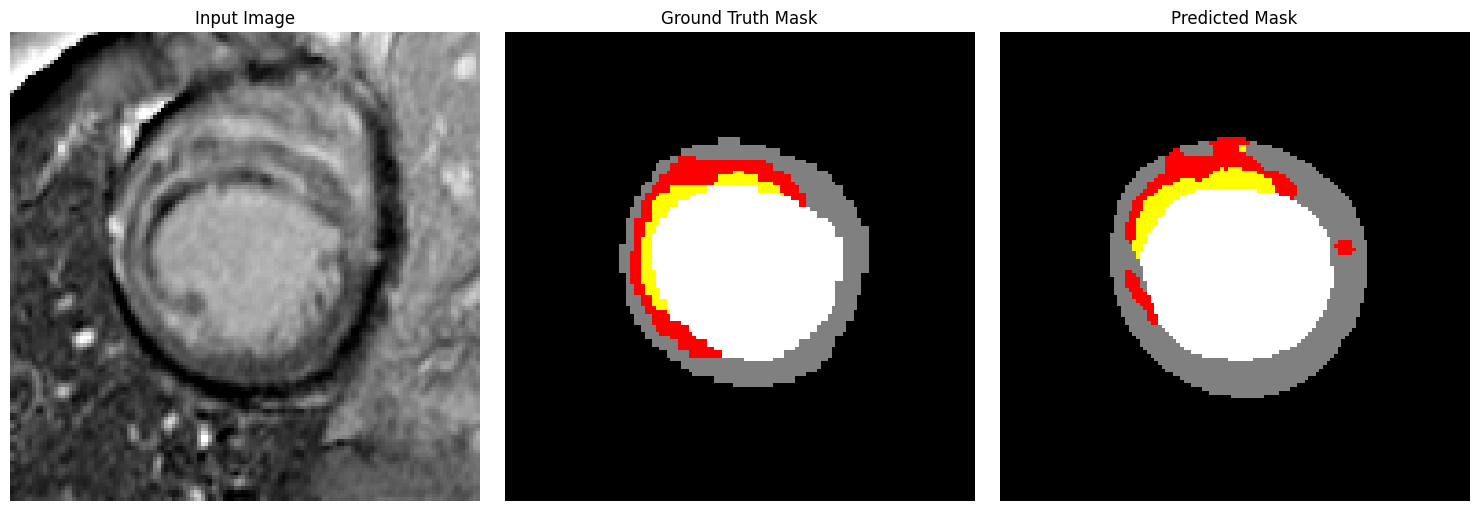

 40%|████      | 32/80 [00:48<01:07,  1.41s/it]

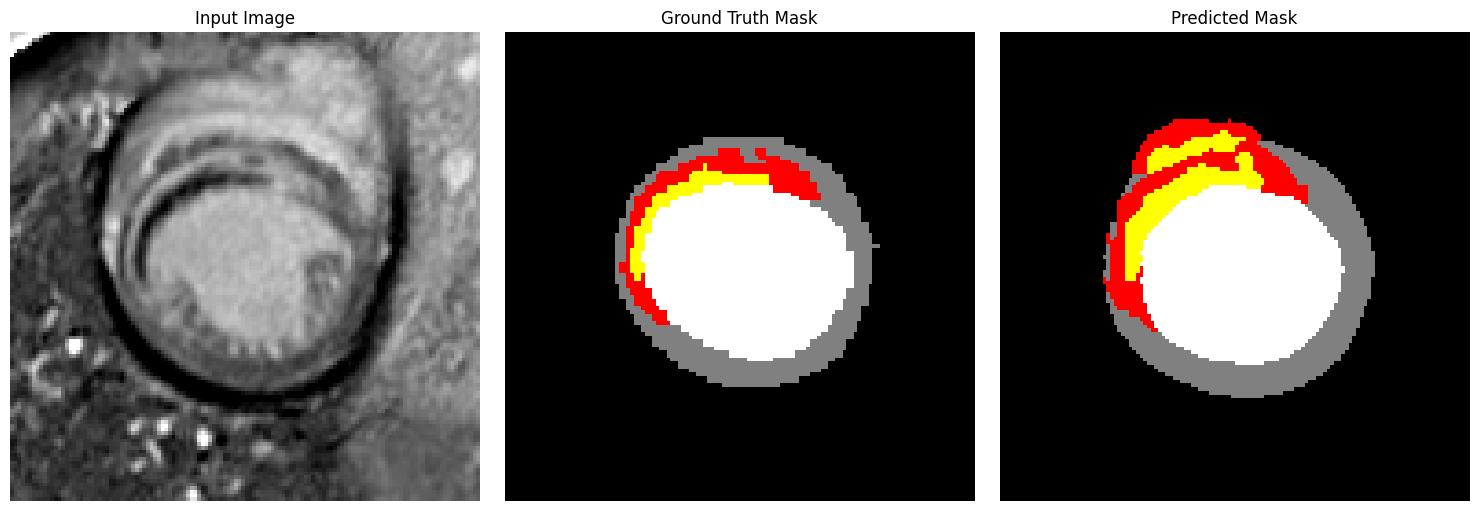

 41%|████▏     | 33/80 [00:50<01:13,  1.56s/it]

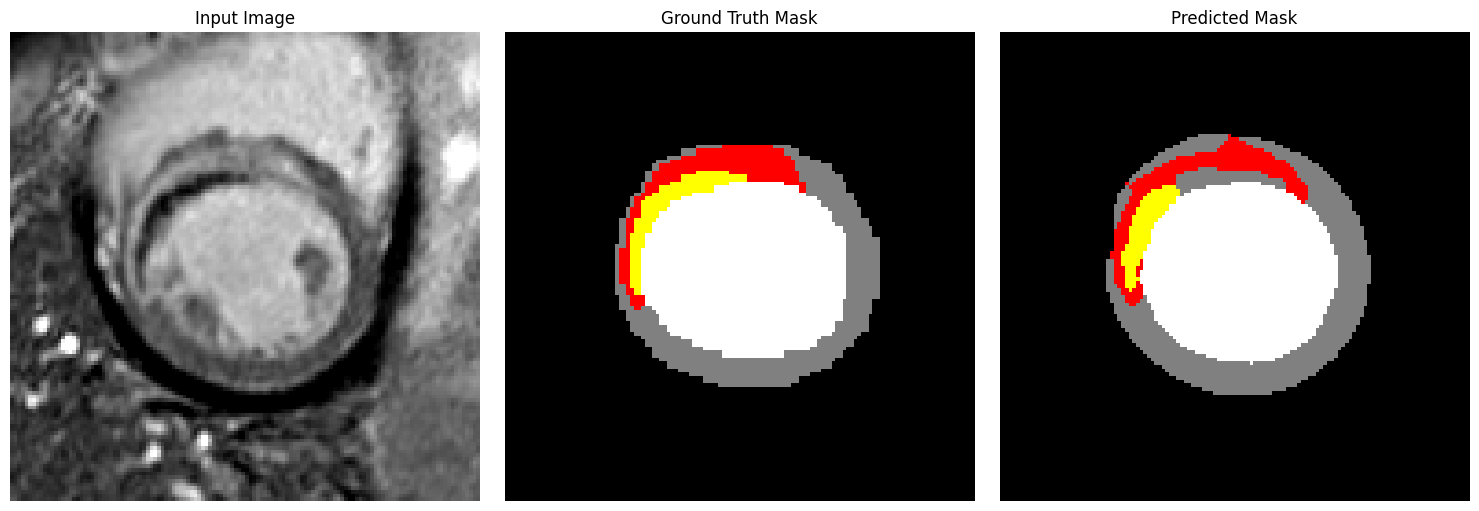

 42%|████▎     | 34/80 [00:52<01:19,  1.73s/it]

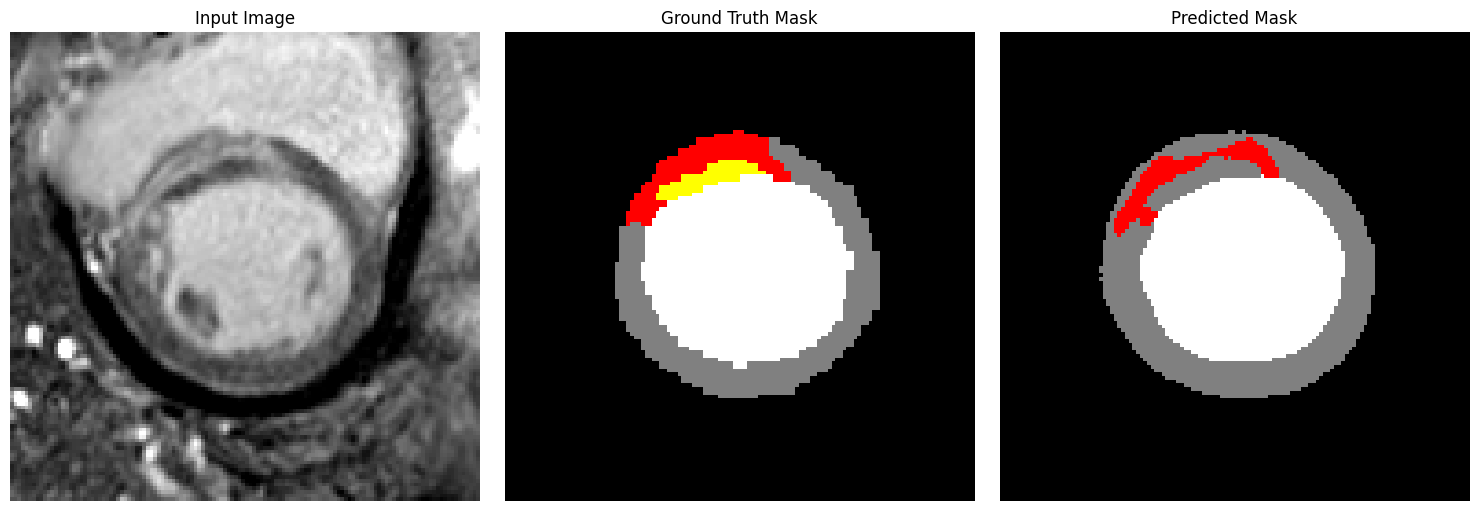

 44%|████▍     | 35/80 [00:53<01:16,  1.70s/it]

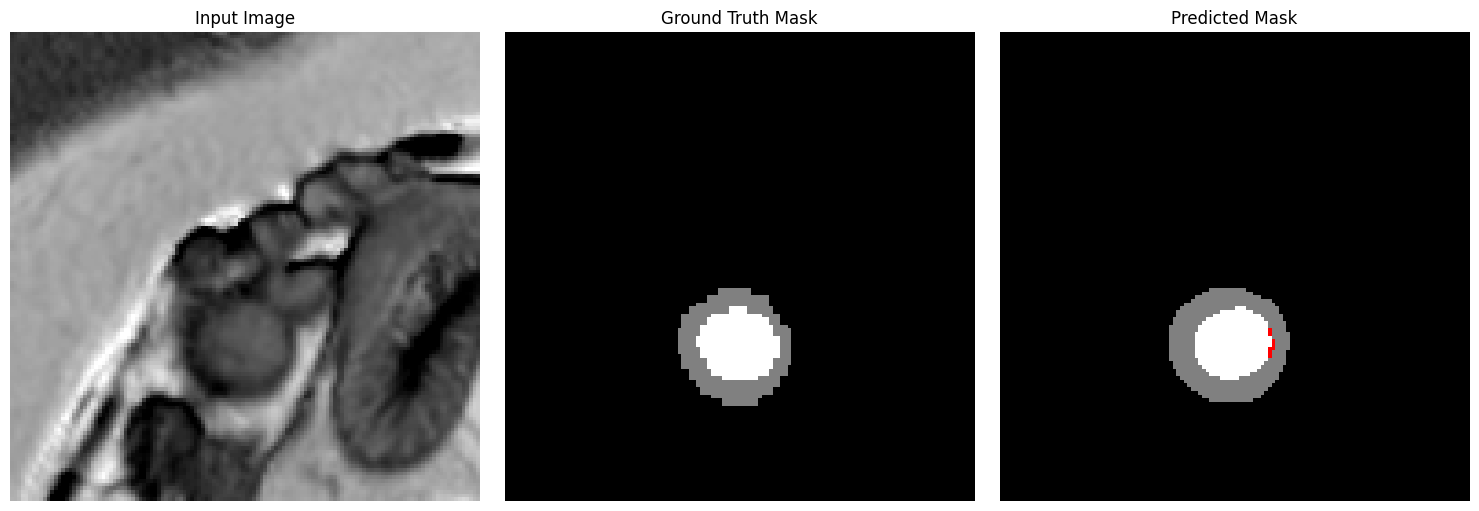

 45%|████▌     | 36/80 [00:55<01:10,  1.60s/it]

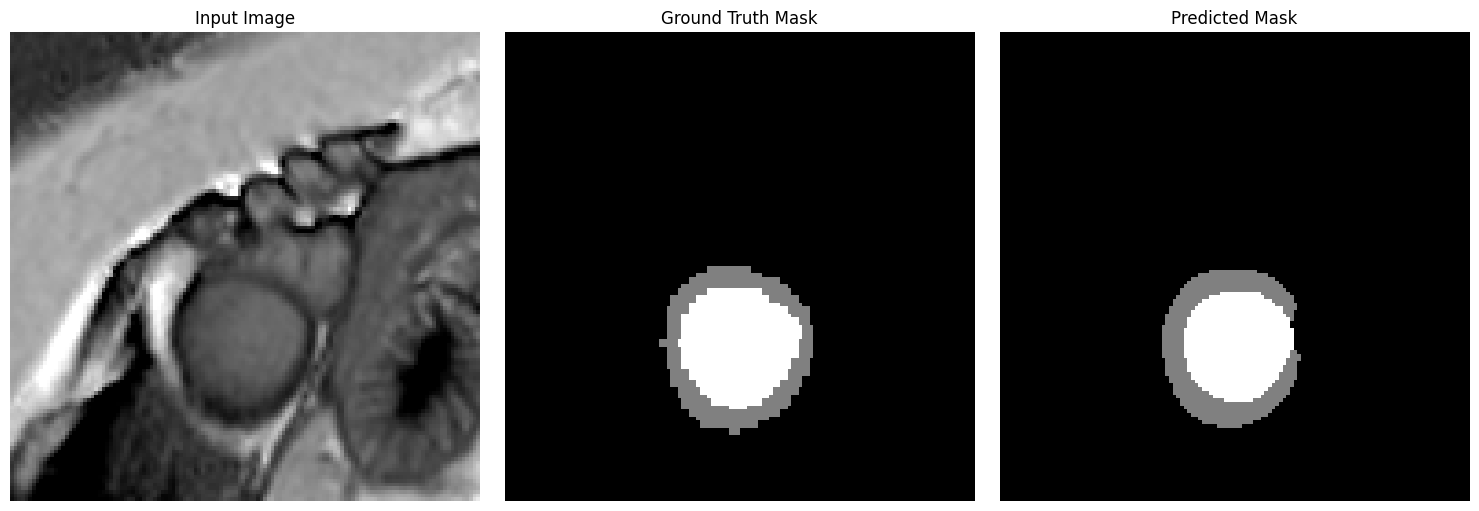

 46%|████▋     | 37/80 [00:56<01:05,  1.53s/it]

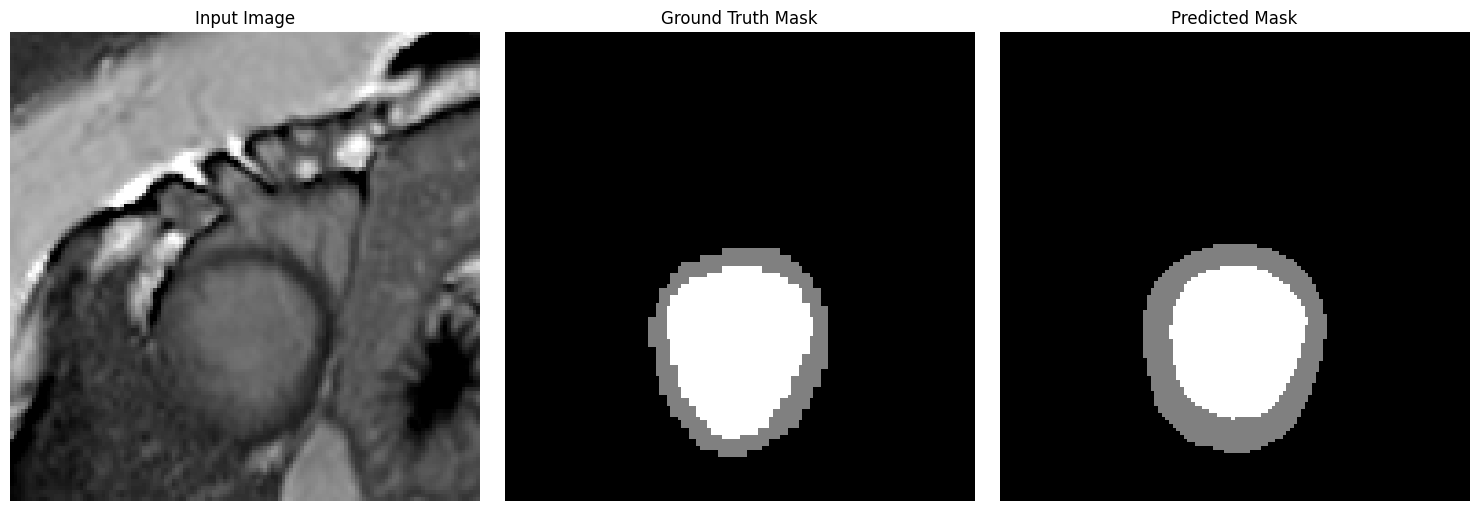

 48%|████▊     | 38/80 [00:58<01:02,  1.49s/it]

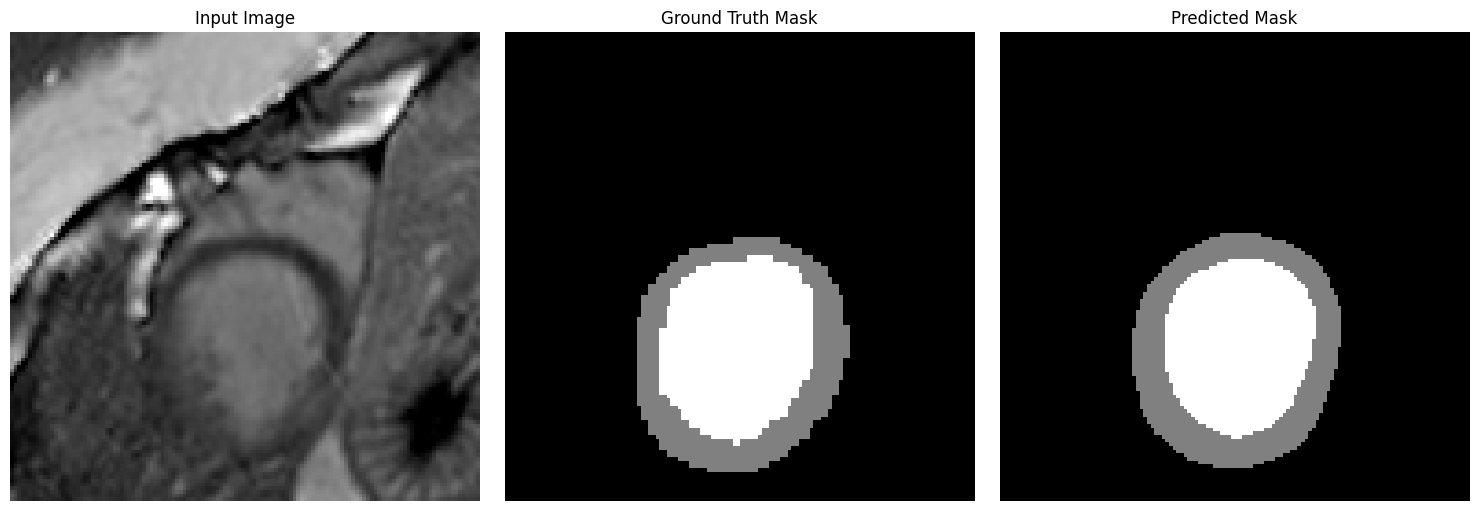

 49%|████▉     | 39/80 [00:59<00:59,  1.45s/it]

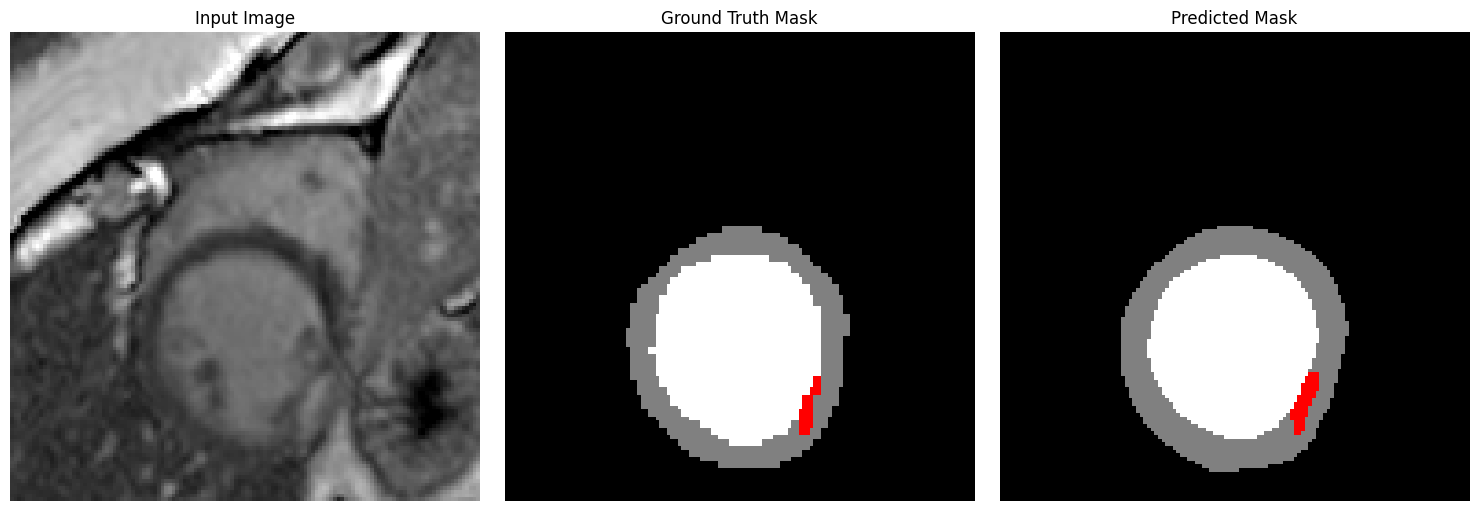

 50%|█████     | 40/80 [01:00<00:56,  1.40s/it]

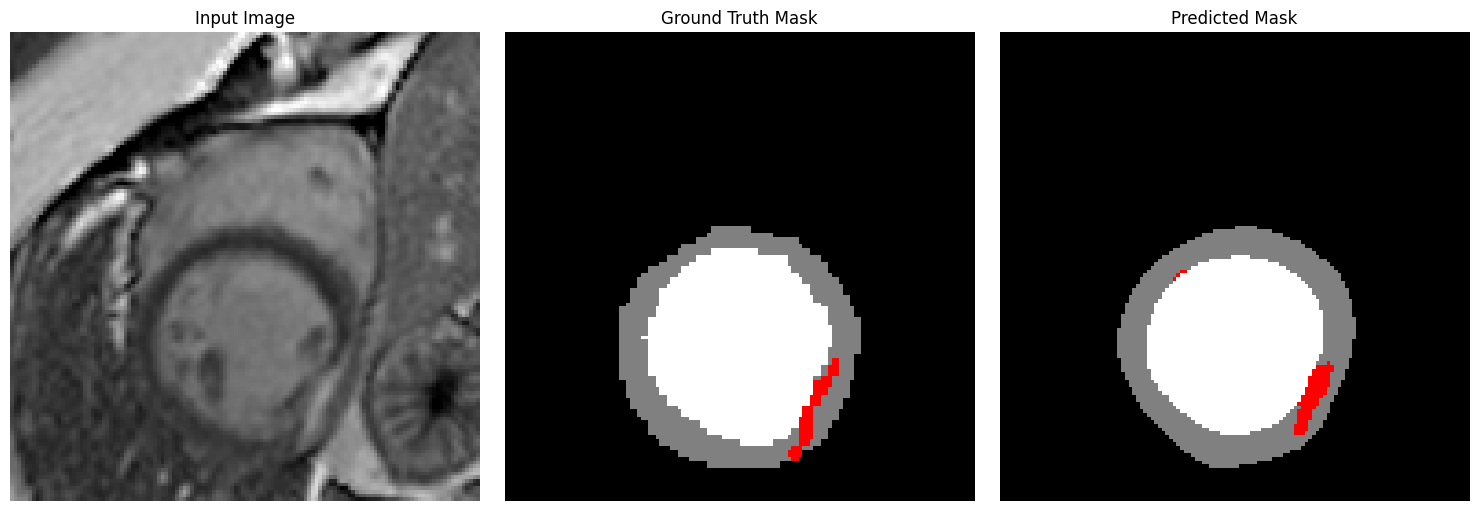

 51%|█████▏    | 41/80 [01:02<00:54,  1.39s/it]

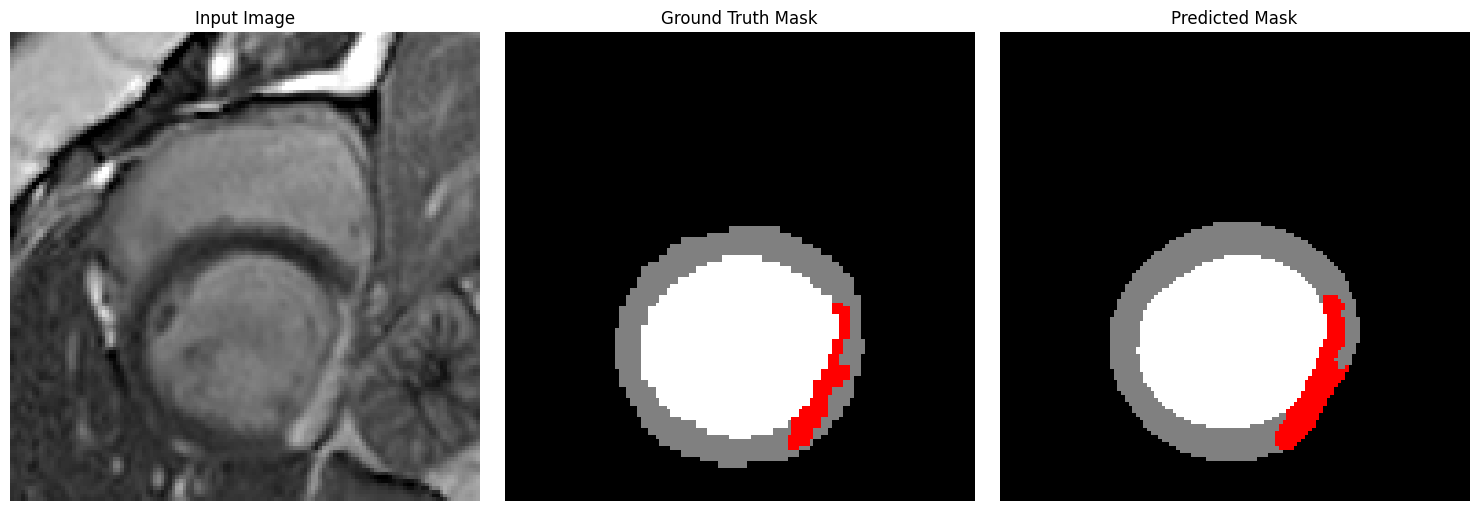

 52%|█████▎    | 42/80 [01:03<00:53,  1.40s/it]

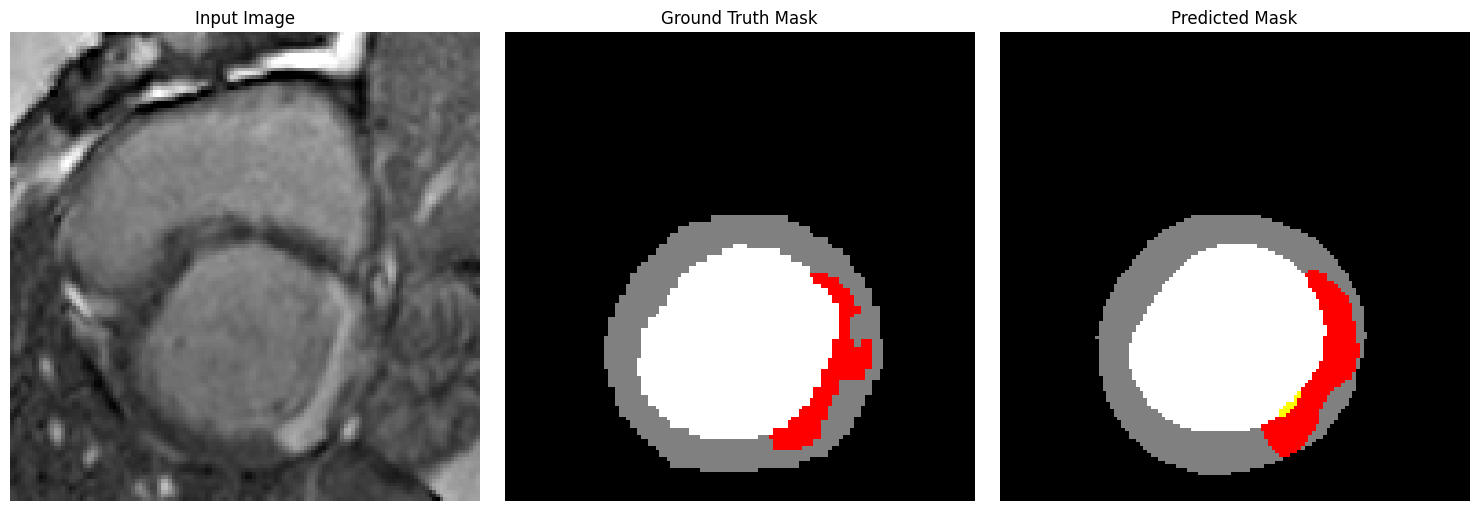

 54%|█████▍    | 43/80 [01:05<00:59,  1.61s/it]

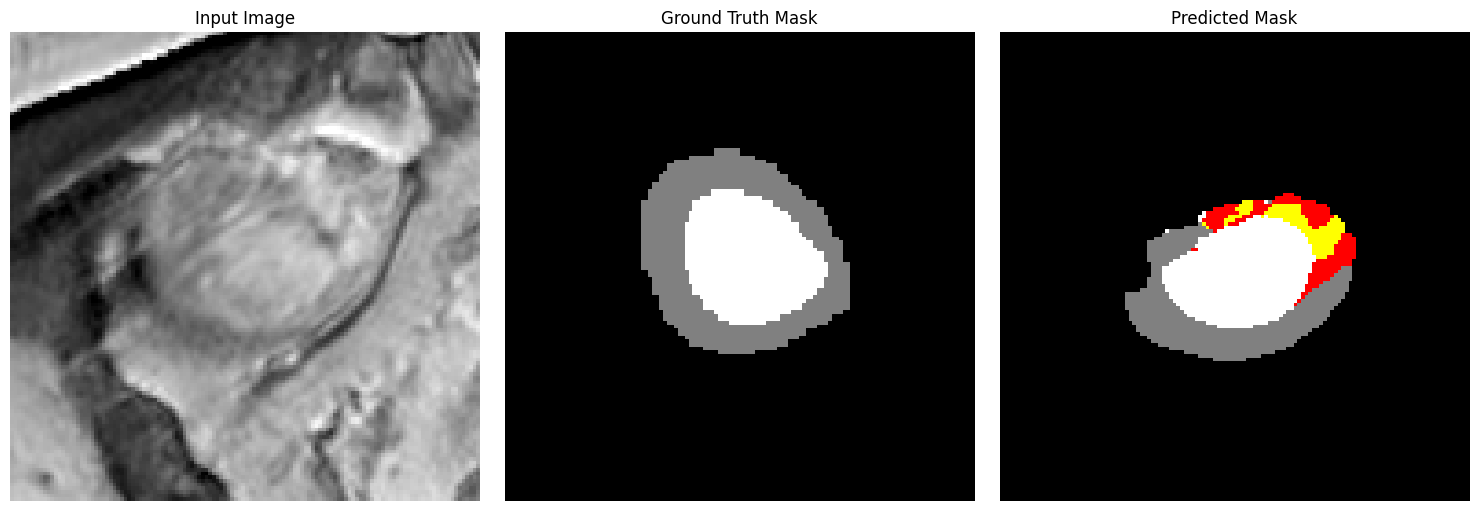

 55%|█████▌    | 44/80 [01:08<01:08,  1.90s/it]

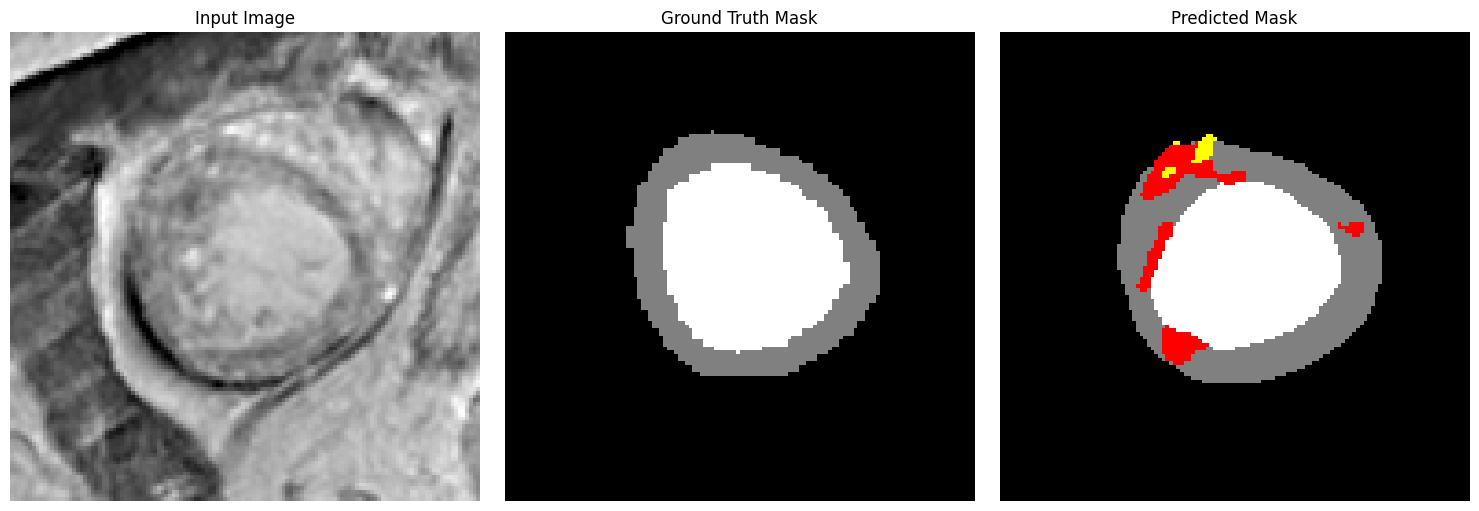

 56%|█████▋    | 45/80 [01:09<01:01,  1.76s/it]

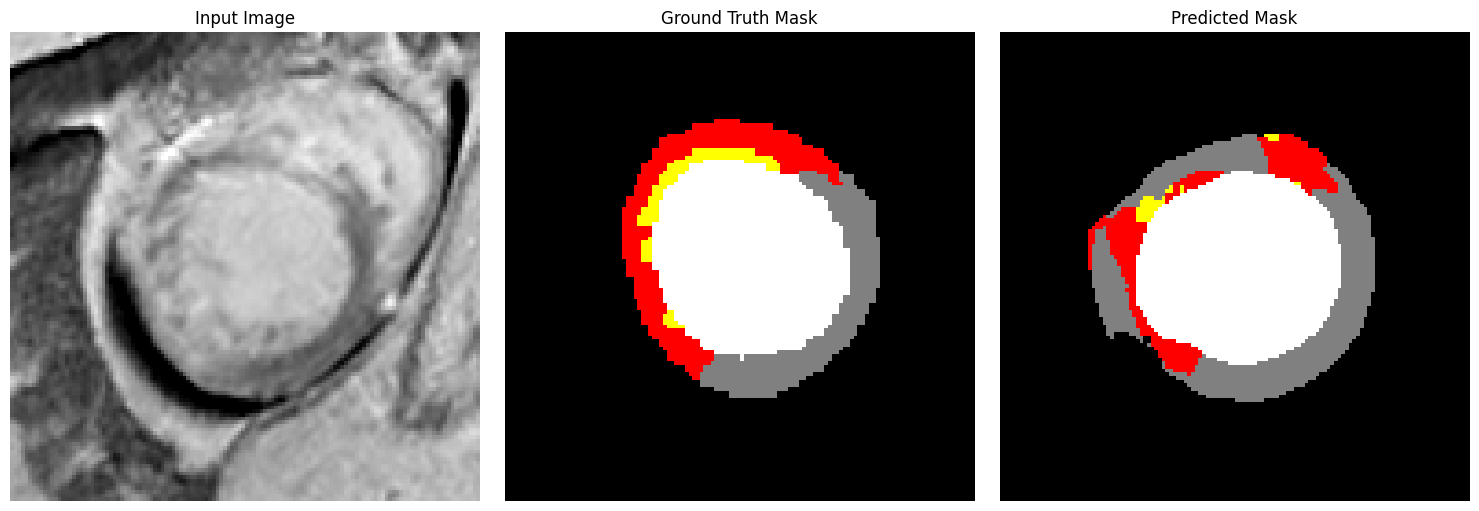

 57%|█████▊    | 46/80 [01:11<00:56,  1.65s/it]

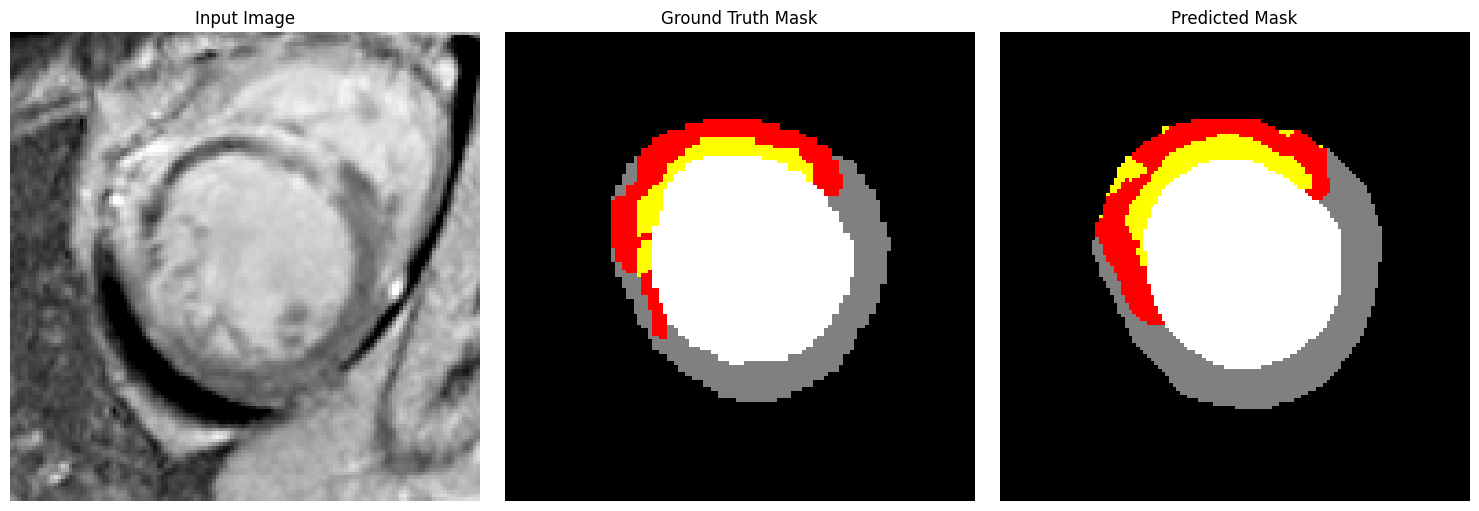

 59%|█████▉    | 47/80 [01:12<00:51,  1.57s/it]

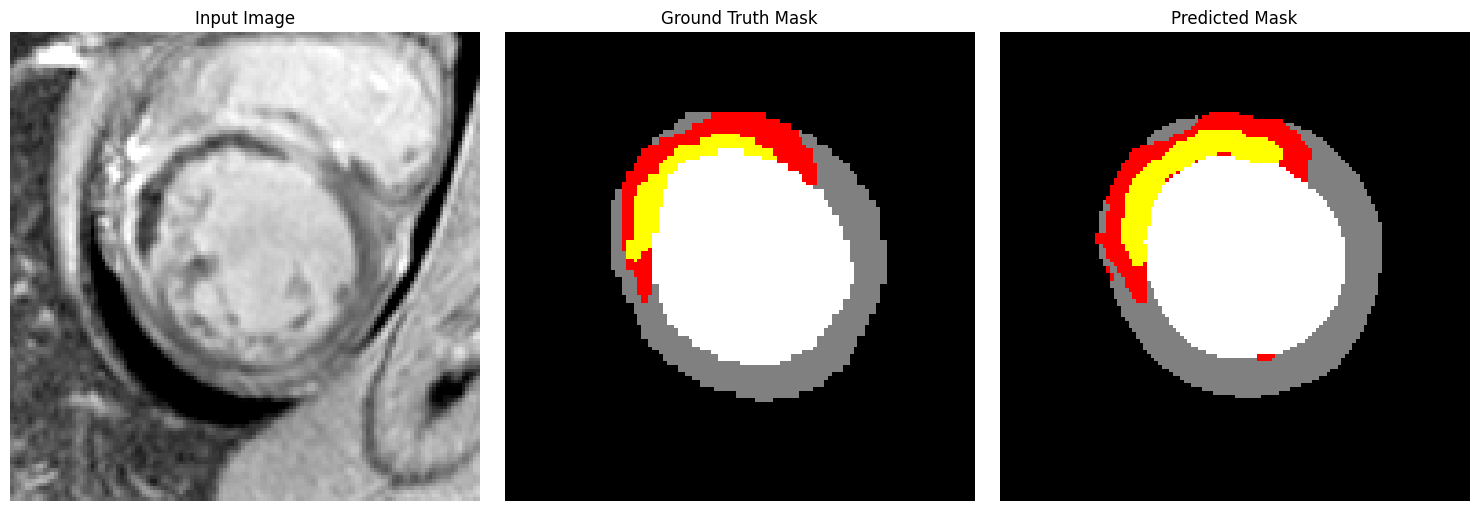

 60%|██████    | 48/80 [01:13<00:48,  1.52s/it]

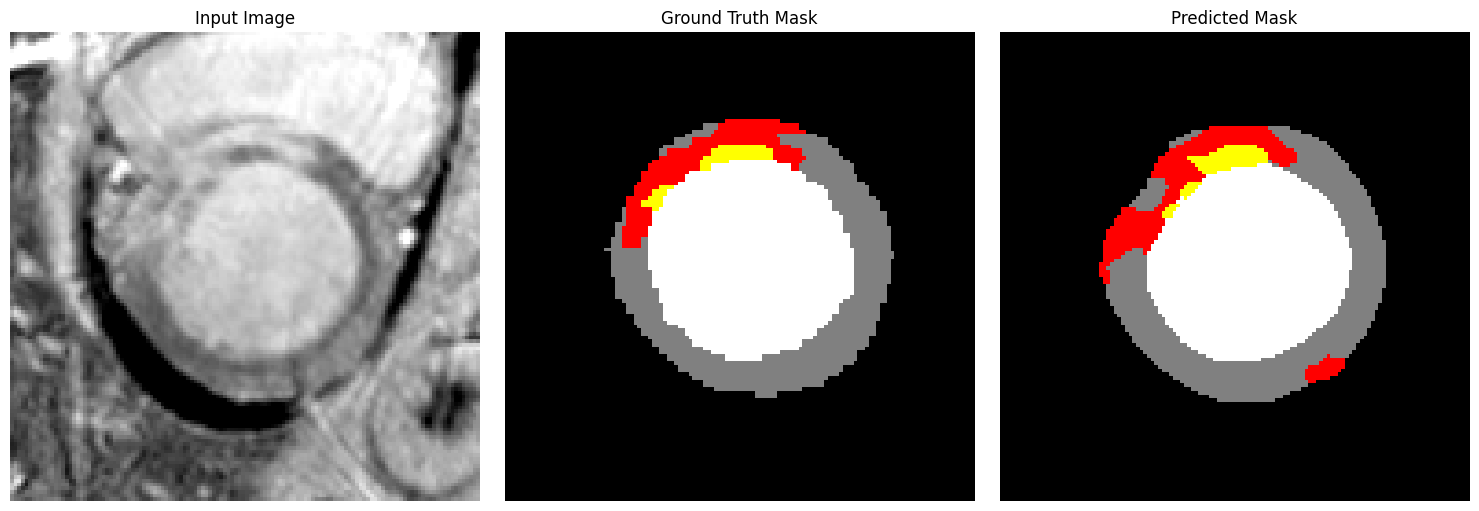

 61%|██████▏   | 49/80 [01:15<00:45,  1.46s/it]

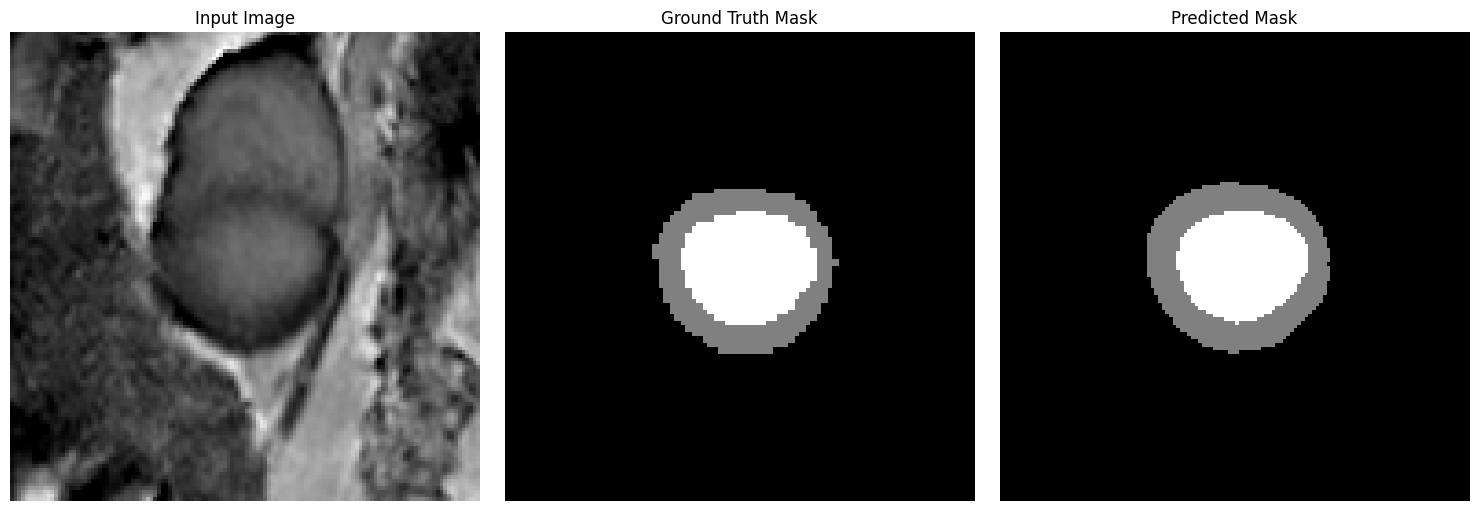

 62%|██████▎   | 50/80 [01:16<00:42,  1.41s/it]

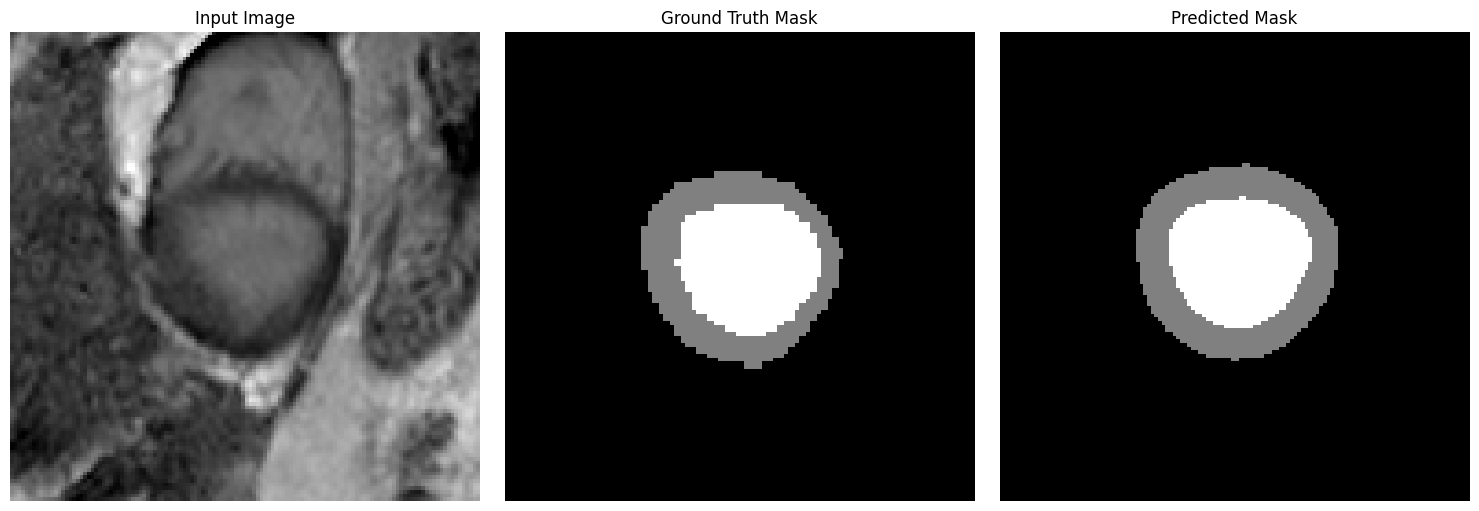

 64%|██████▍   | 51/80 [01:17<00:39,  1.37s/it]

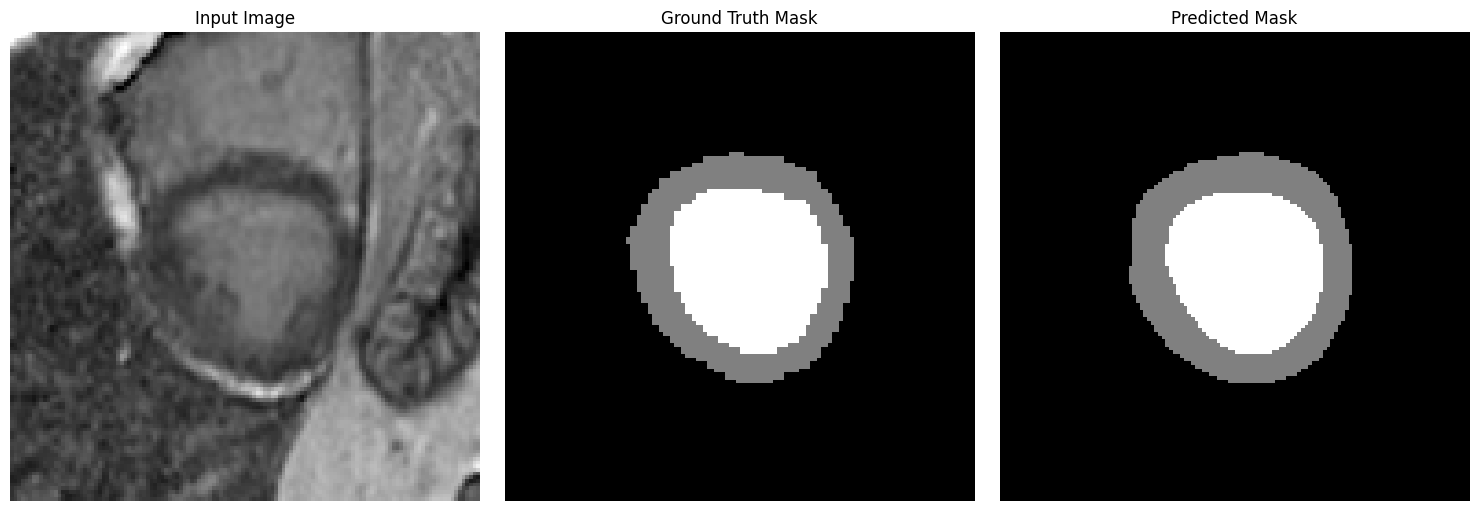

 65%|██████▌   | 52/80 [01:19<00:44,  1.59s/it]

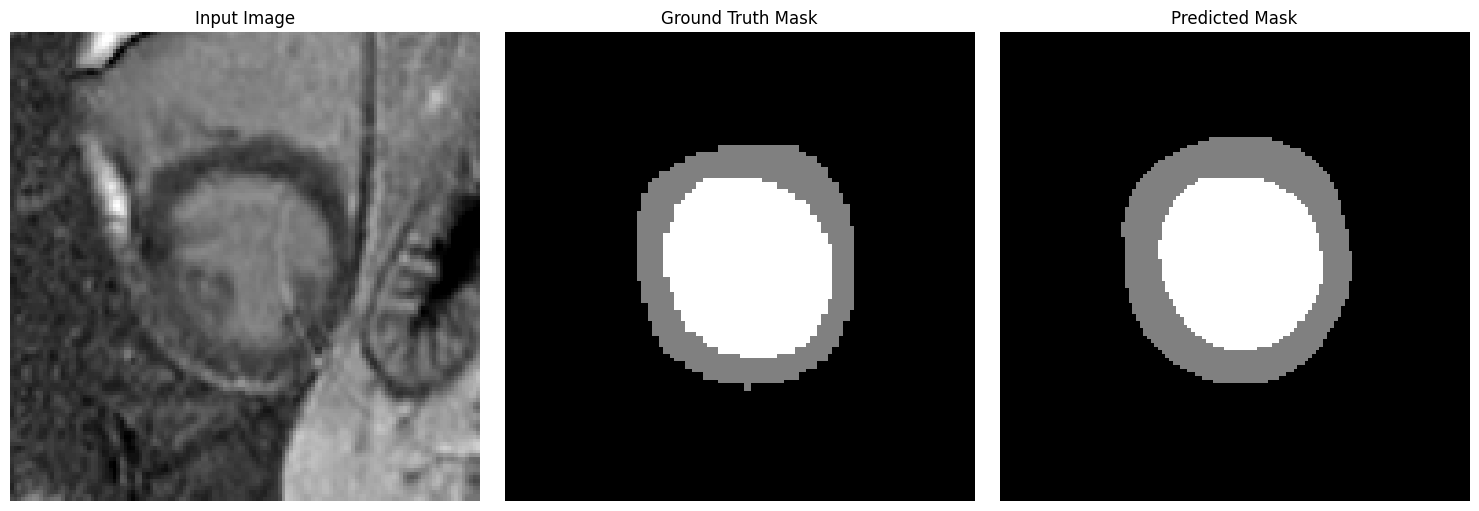

 66%|██████▋   | 53/80 [01:22<00:47,  1.78s/it]

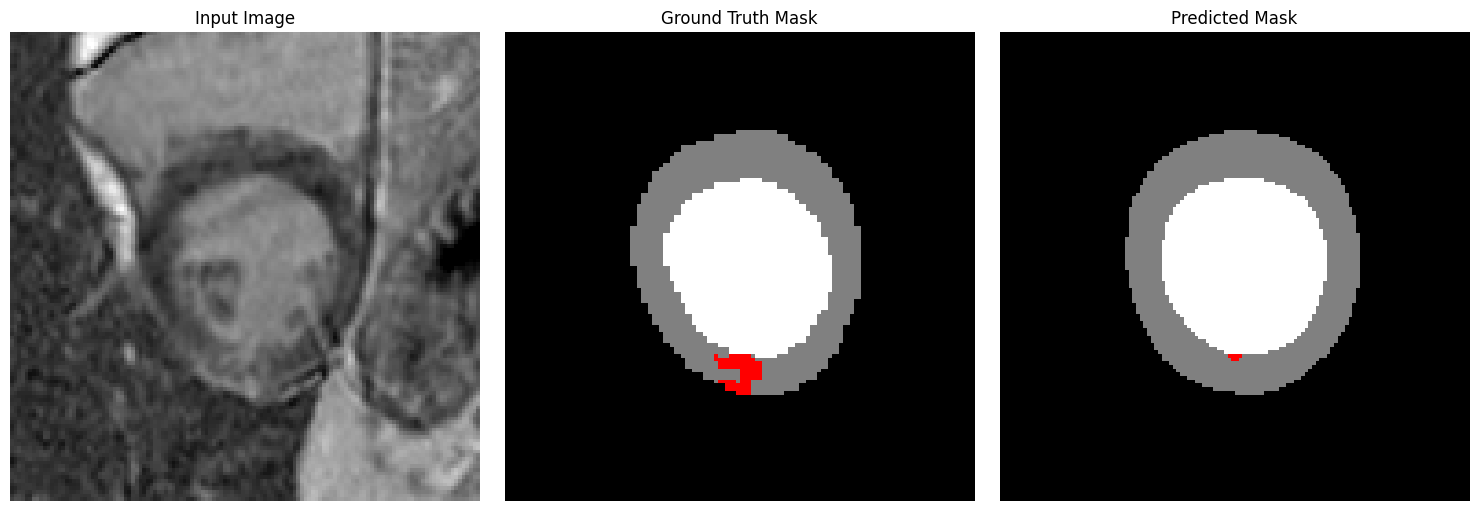

 68%|██████▊   | 54/80 [01:23<00:44,  1.70s/it]

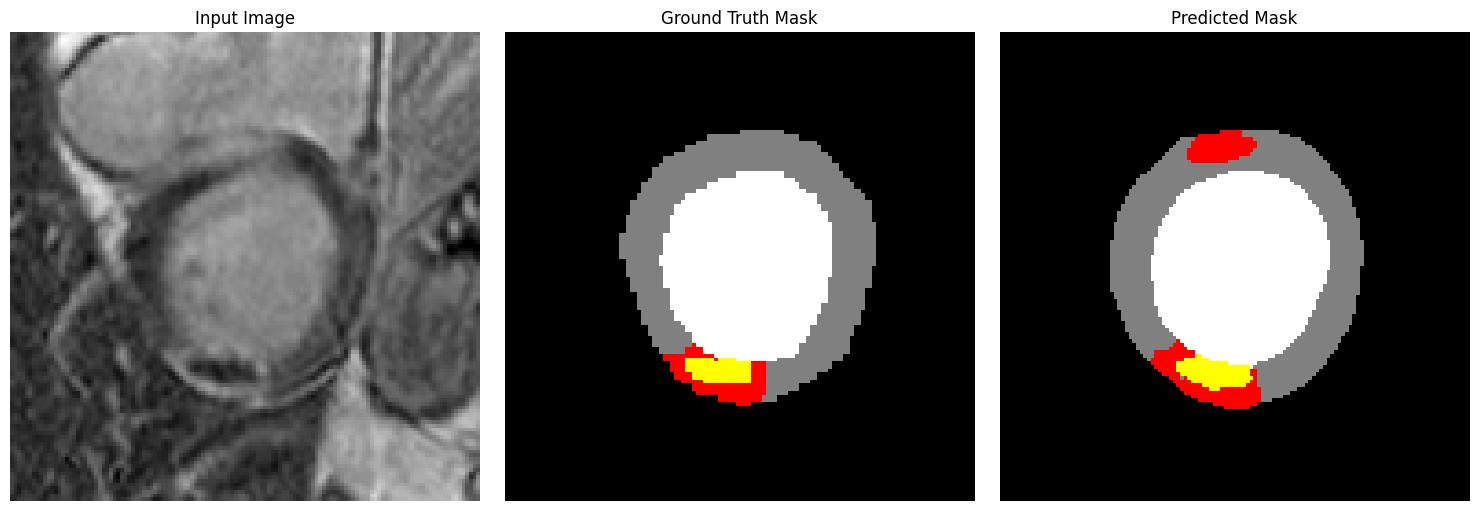

 69%|██████▉   | 55/80 [01:24<00:40,  1.61s/it]

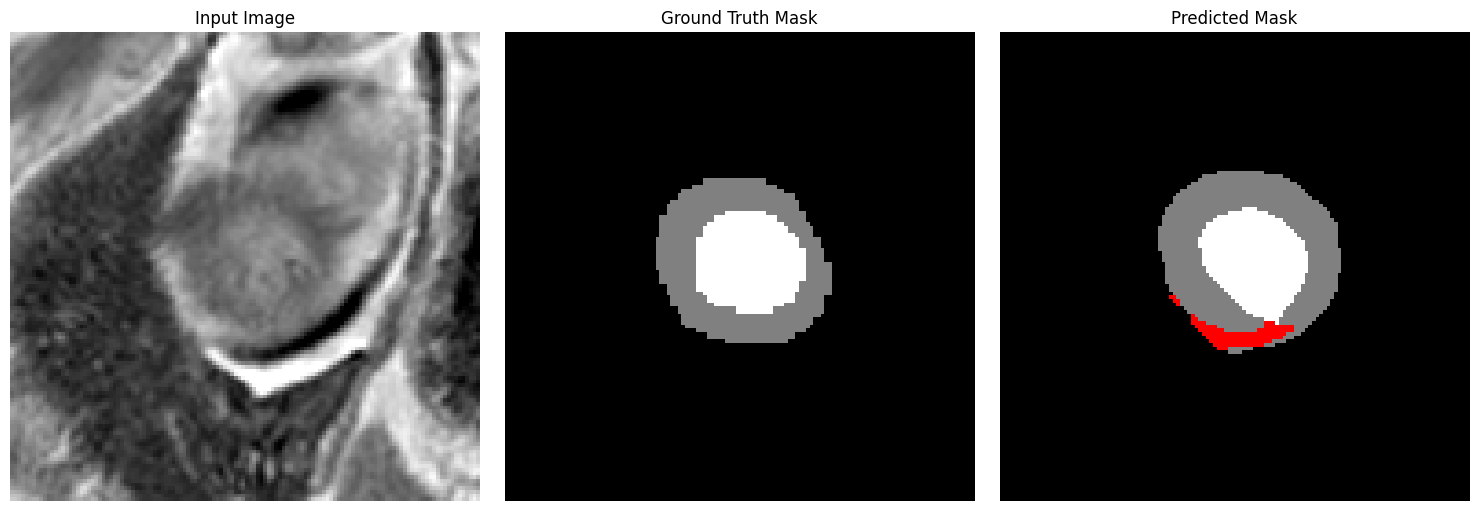

 70%|███████   | 56/80 [01:26<00:36,  1.52s/it]

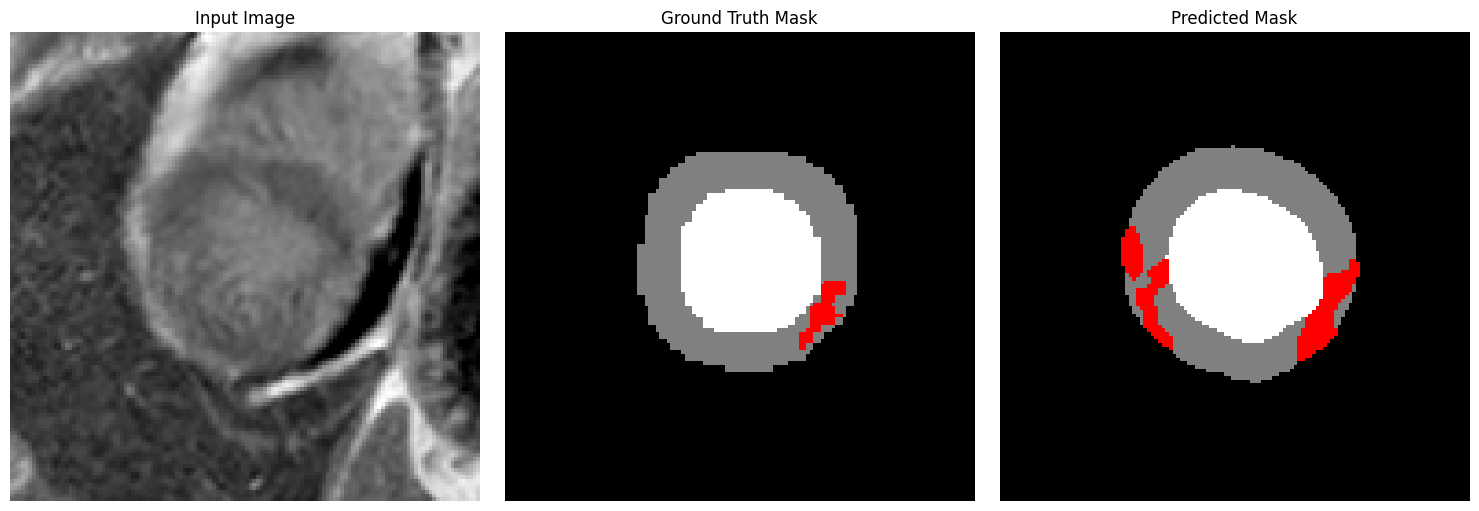

 71%|███████▏  | 57/80 [01:27<00:34,  1.49s/it]

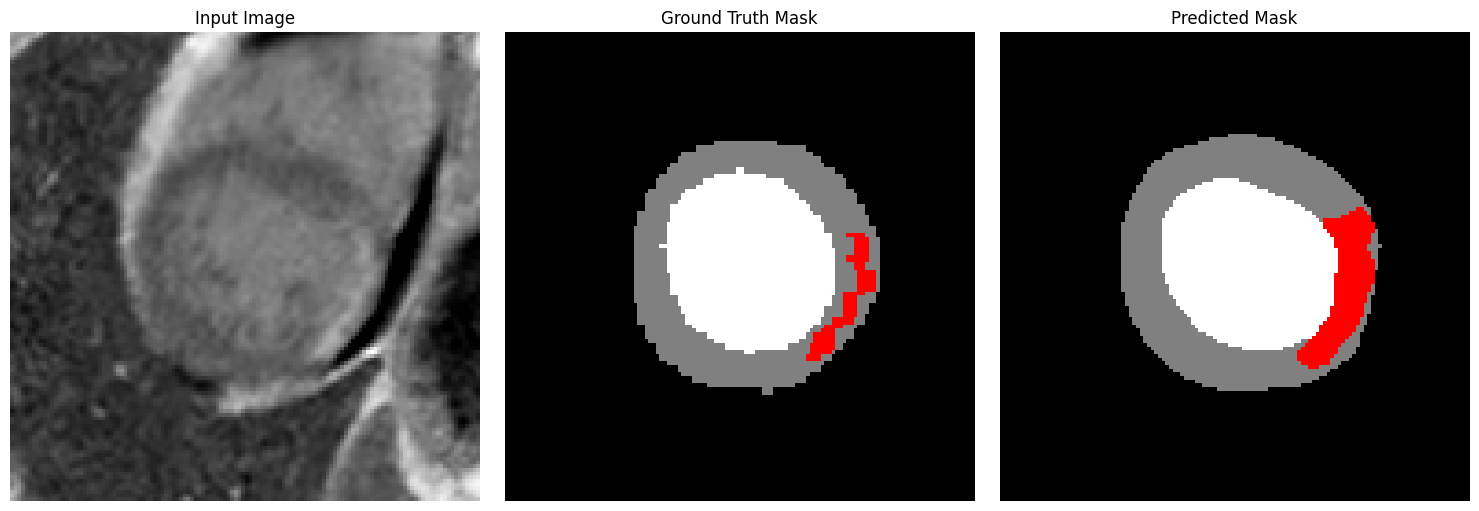

 72%|███████▎  | 58/80 [01:29<00:32,  1.47s/it]

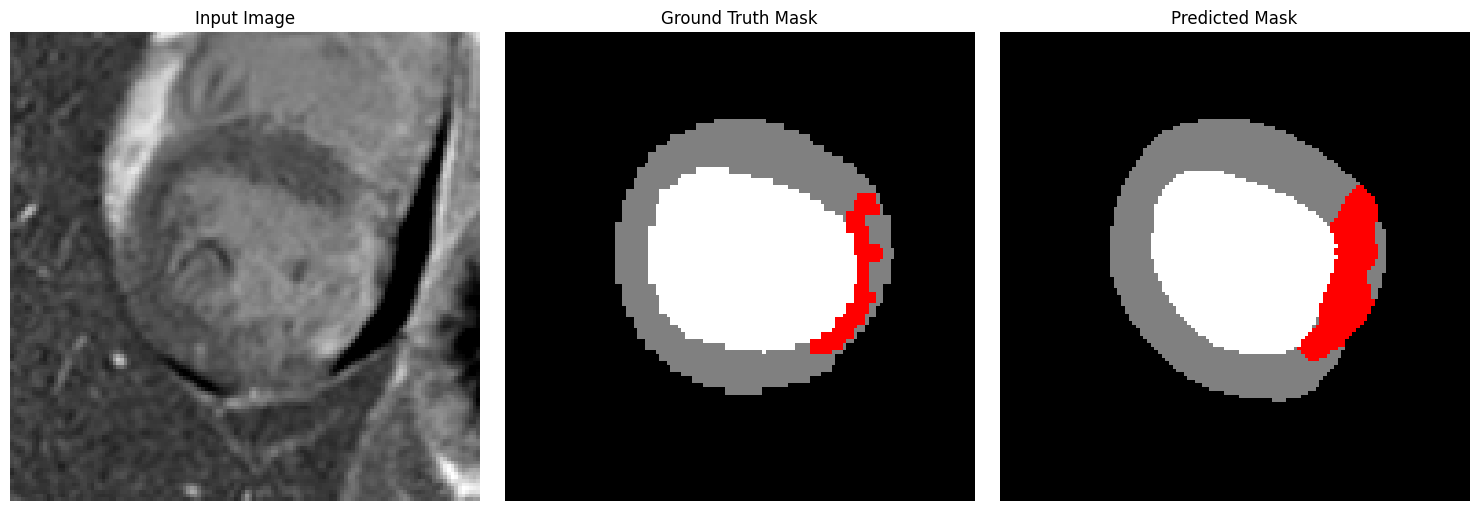

 74%|███████▍  | 59/80 [01:30<00:29,  1.42s/it]

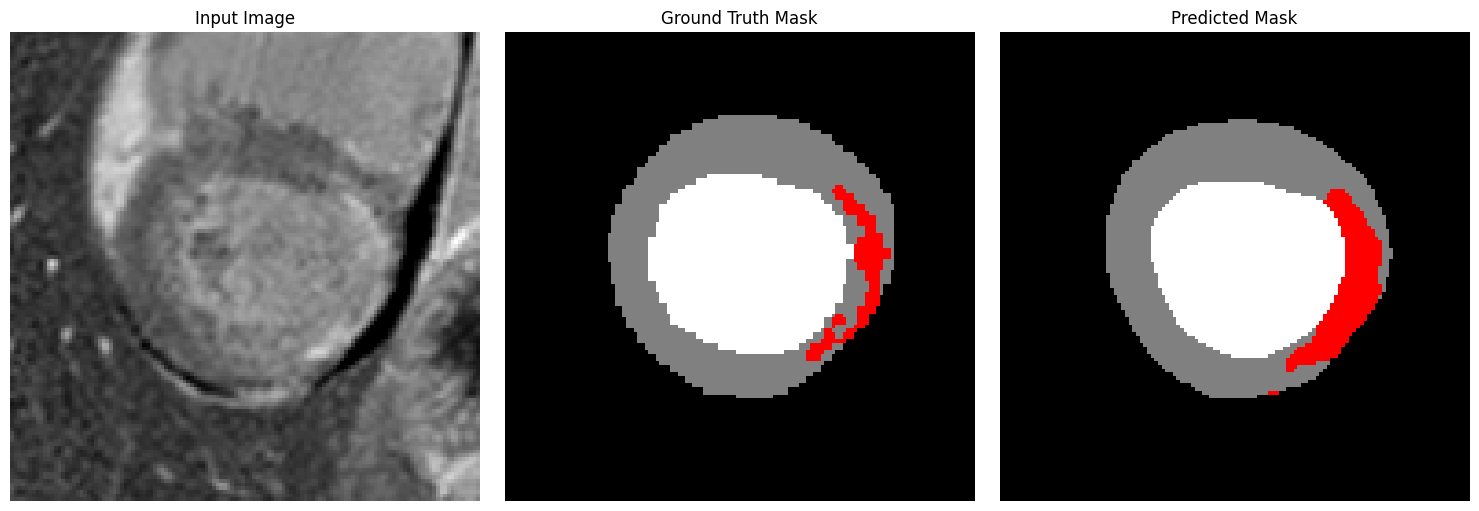

 75%|███████▌  | 60/80 [01:31<00:27,  1.38s/it]

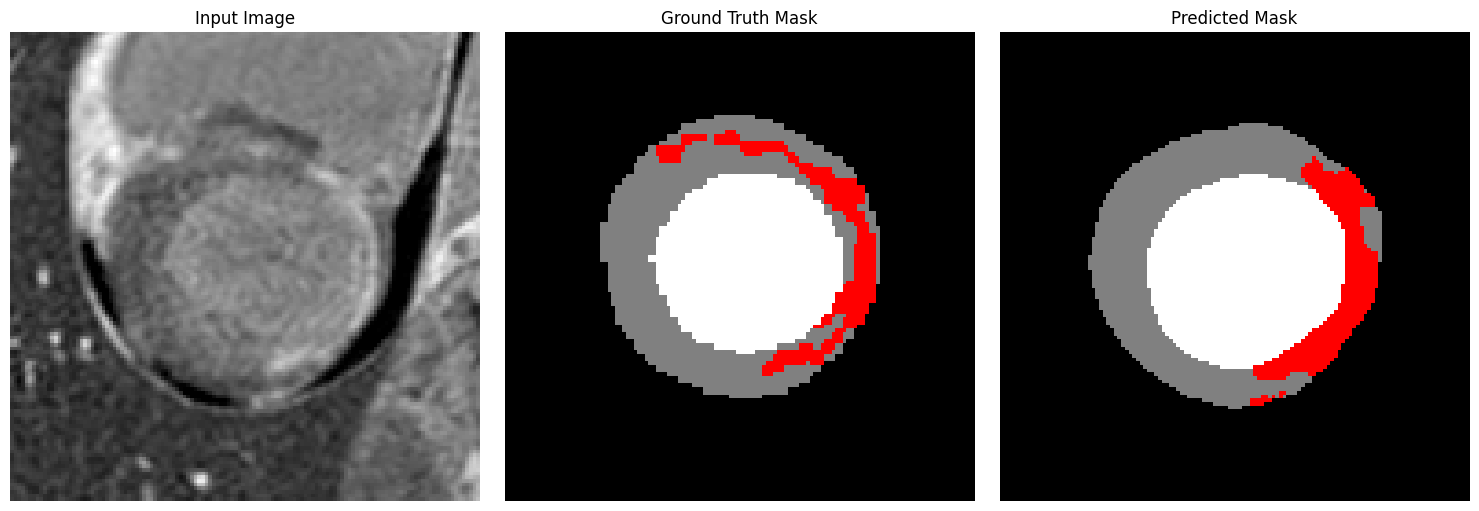

 76%|███████▋  | 61/80 [01:33<00:28,  1.50s/it]

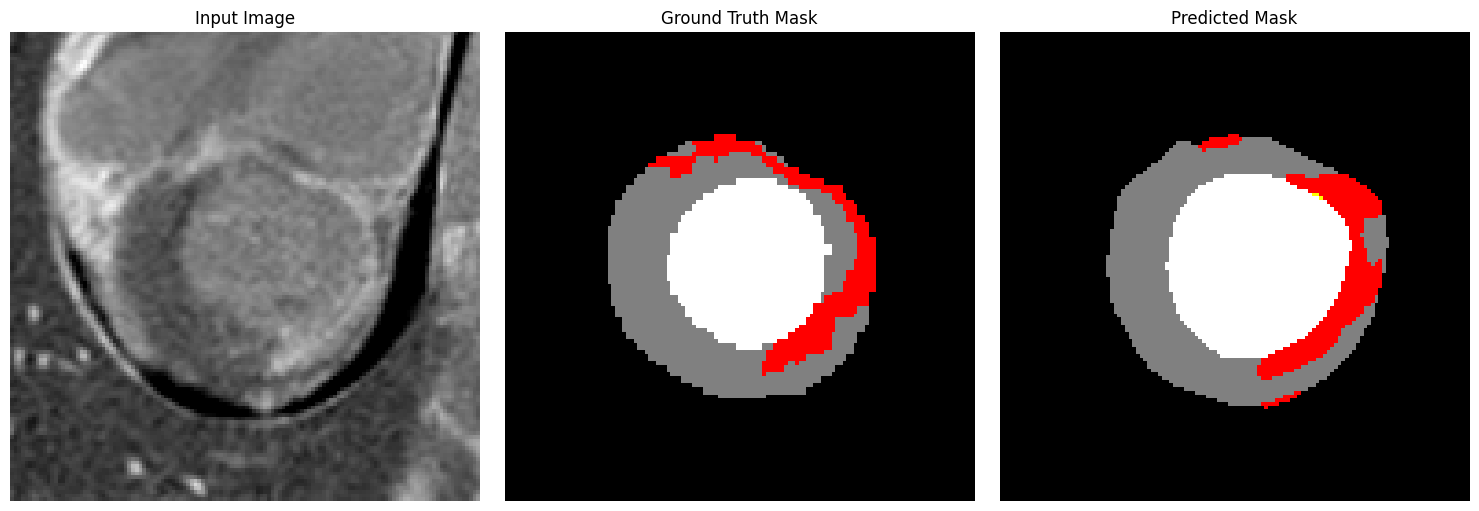

 78%|███████▊  | 62/80 [01:35<00:30,  1.71s/it]

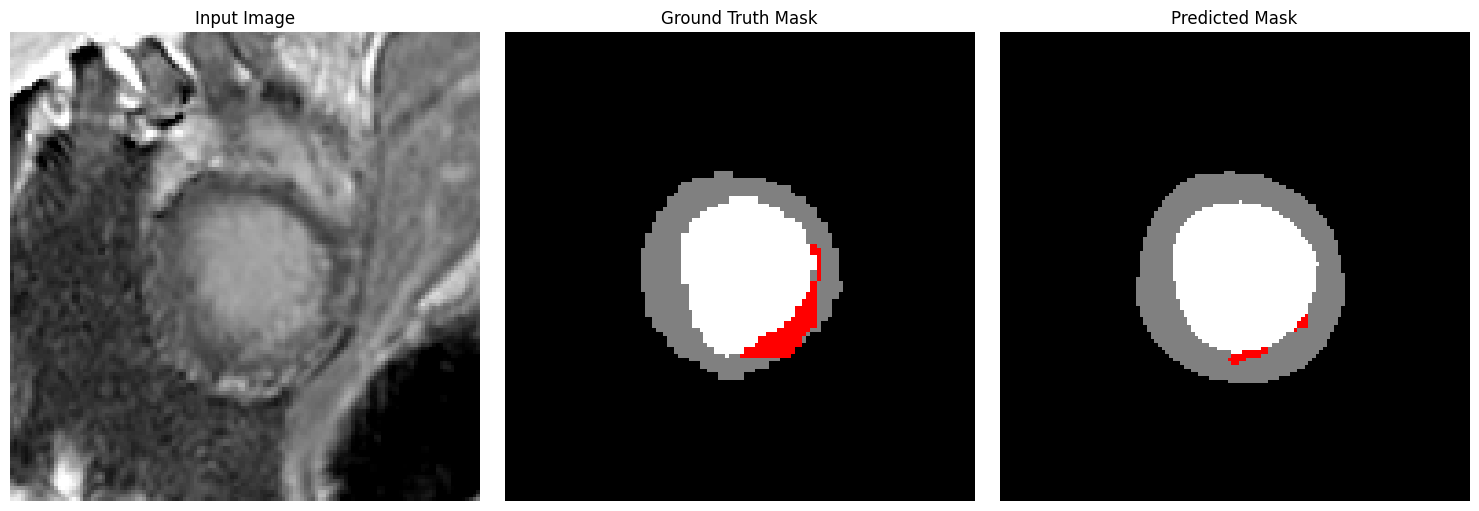

 79%|███████▉  | 63/80 [01:38<00:32,  1.94s/it]

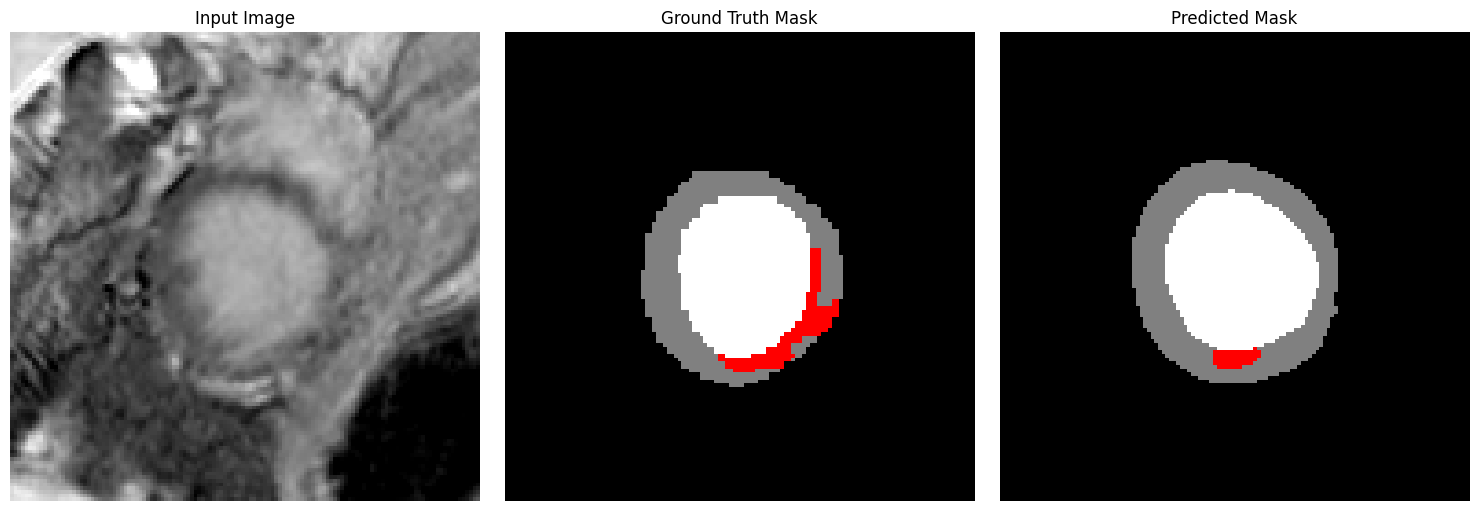

 80%|████████  | 64/80 [01:39<00:28,  1.76s/it]

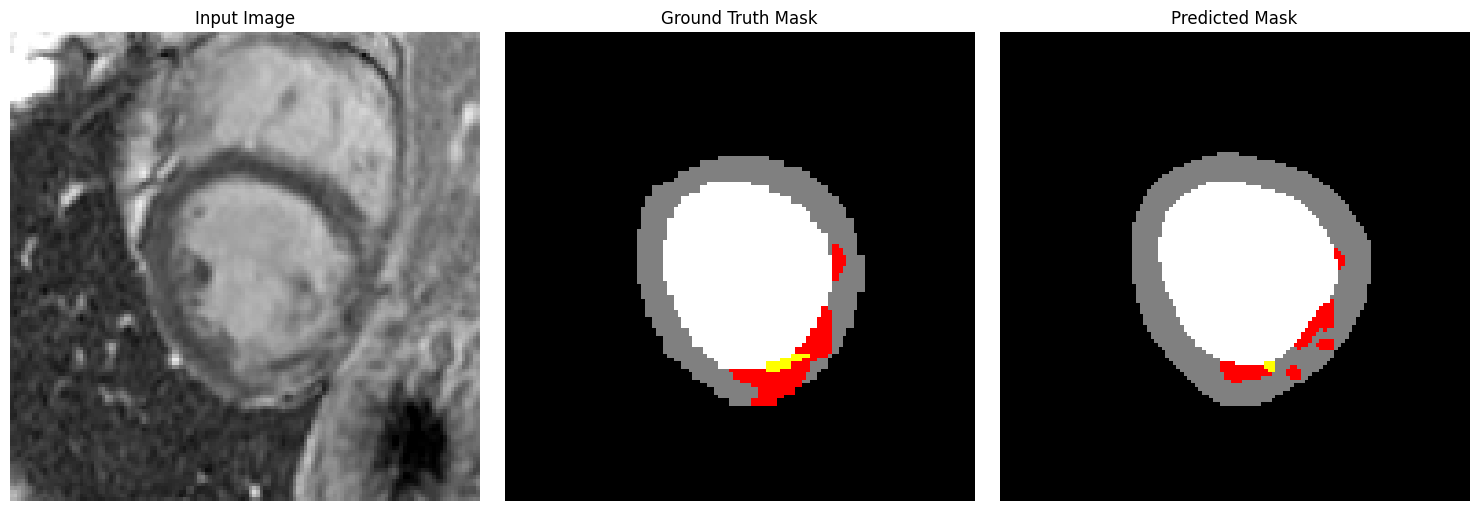

 81%|████████▏ | 65/80 [01:40<00:24,  1.66s/it]

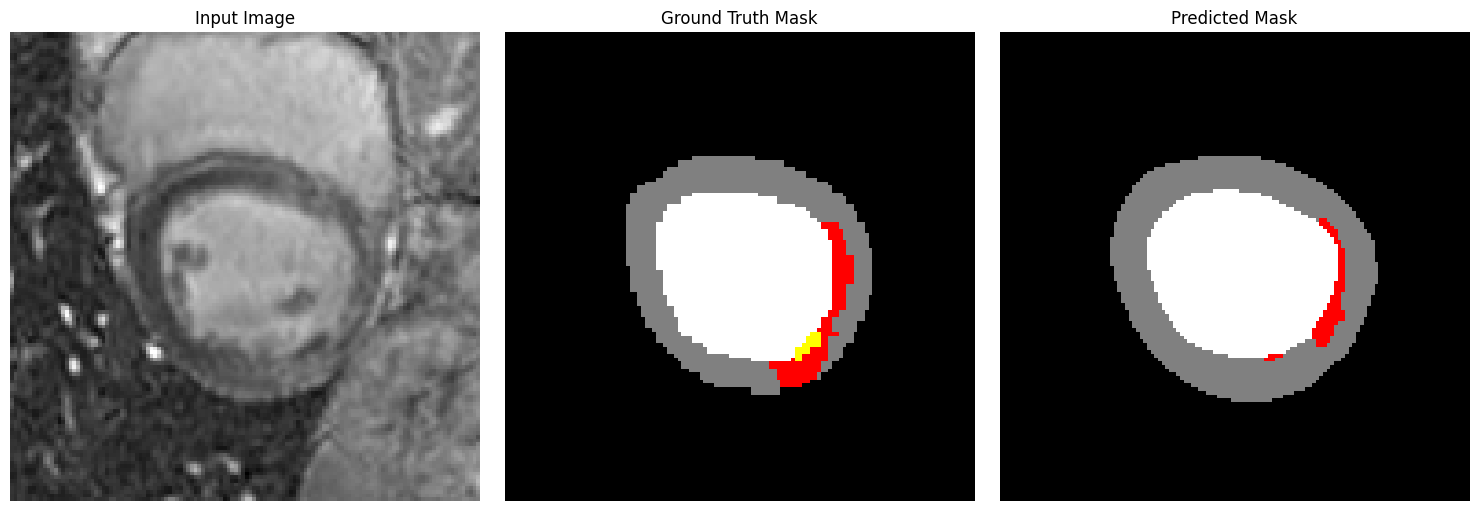

 82%|████████▎ | 66/80 [01:42<00:21,  1.57s/it]

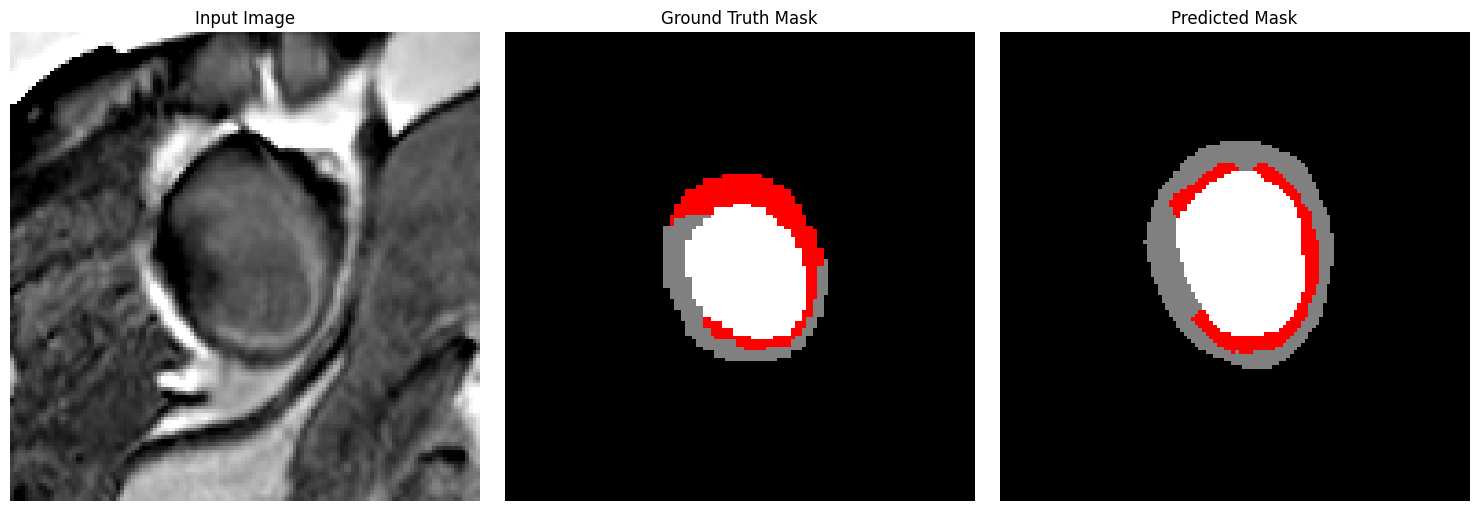

 84%|████████▍ | 67/80 [01:43<00:19,  1.49s/it]

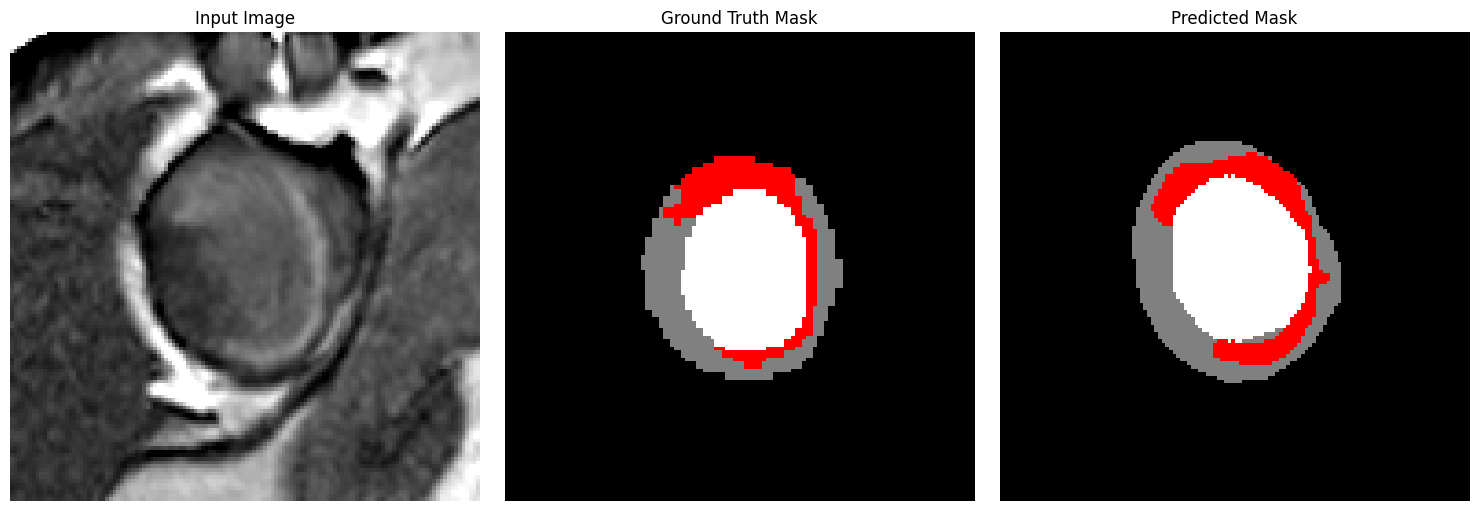

 85%|████████▌ | 68/80 [01:45<00:17,  1.49s/it]

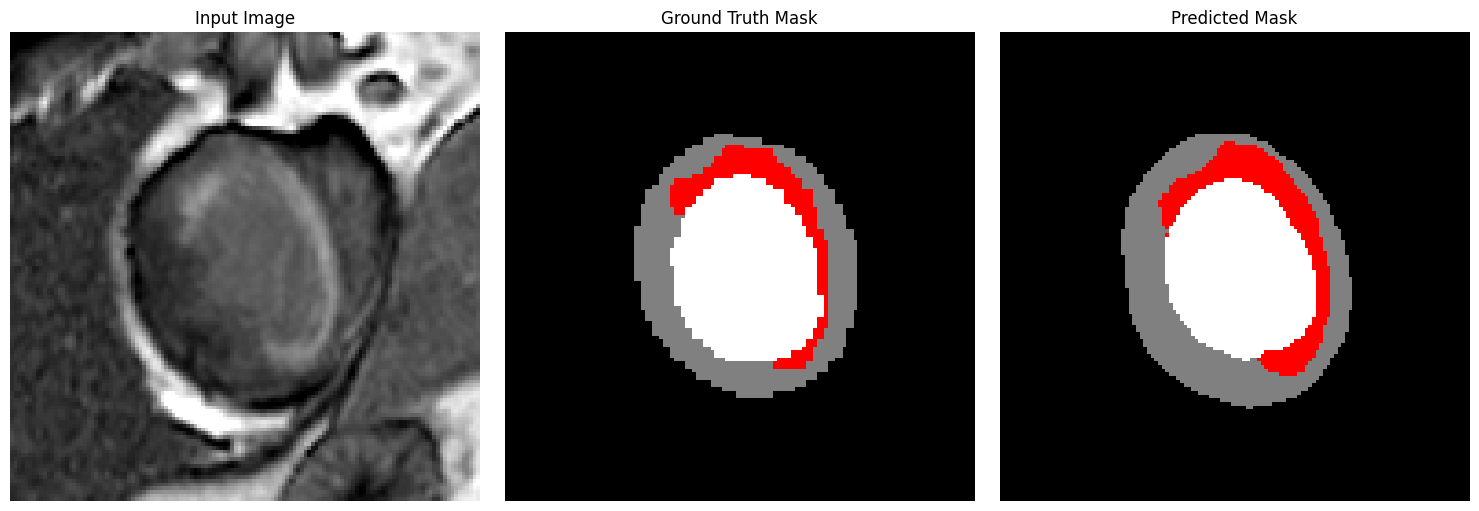

 86%|████████▋ | 69/80 [01:46<00:15,  1.45s/it]

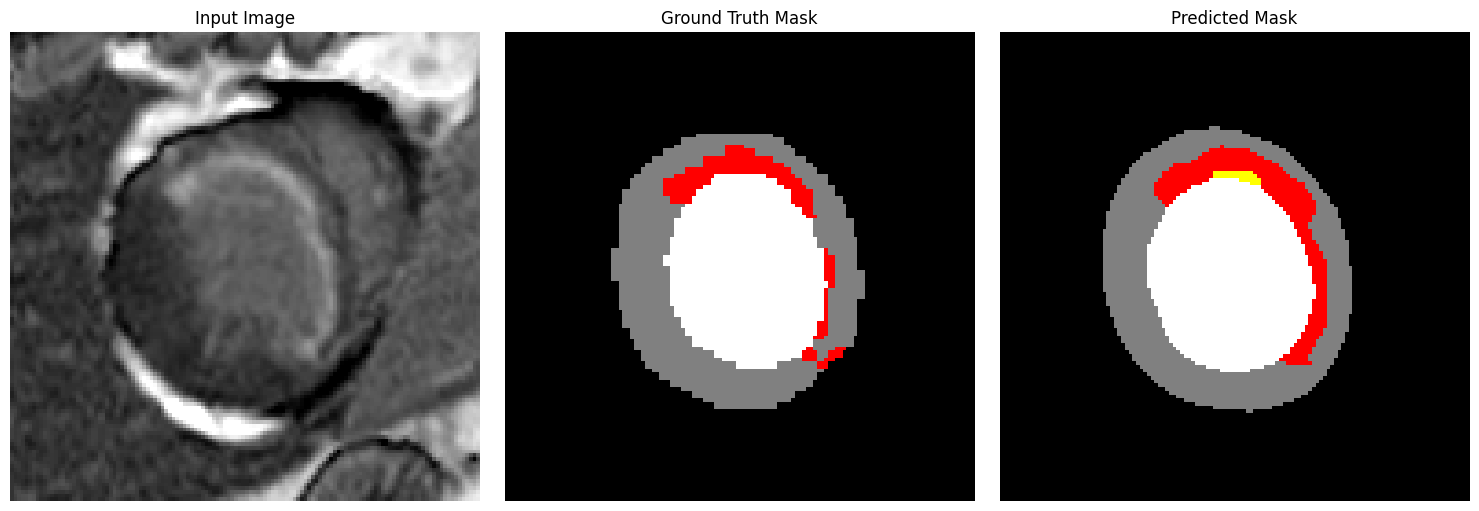

 88%|████████▊ | 70/80 [01:48<00:15,  1.52s/it]

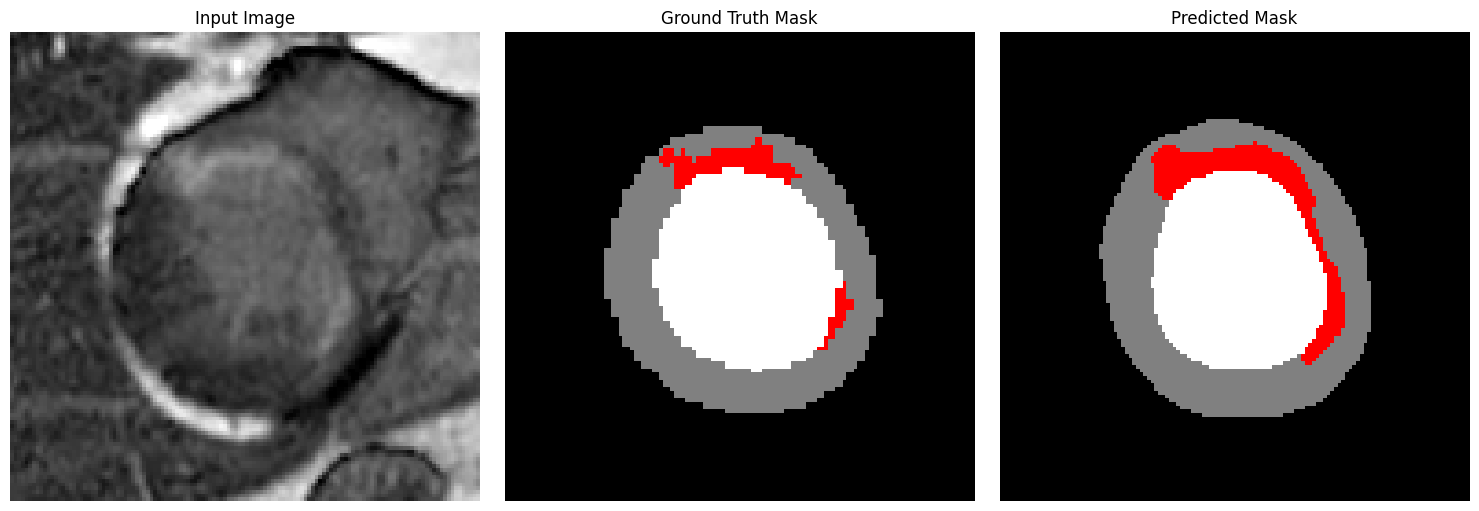

 89%|████████▉ | 71/80 [01:50<00:15,  1.73s/it]

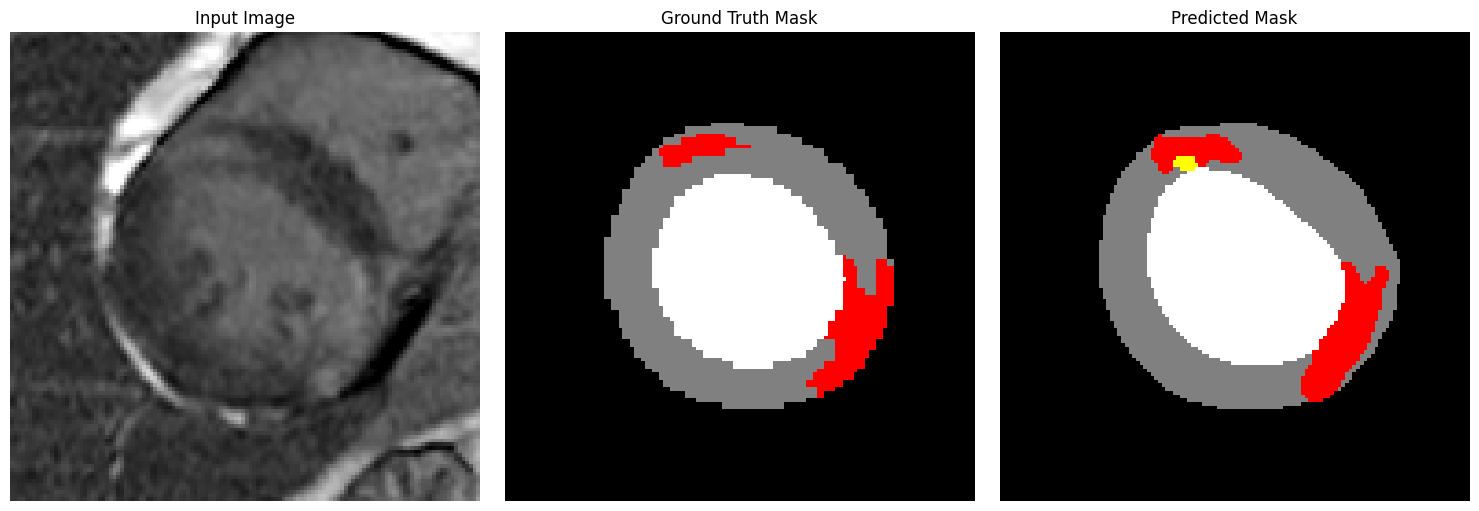

 90%|█████████ | 72/80 [01:52<00:14,  1.80s/it]

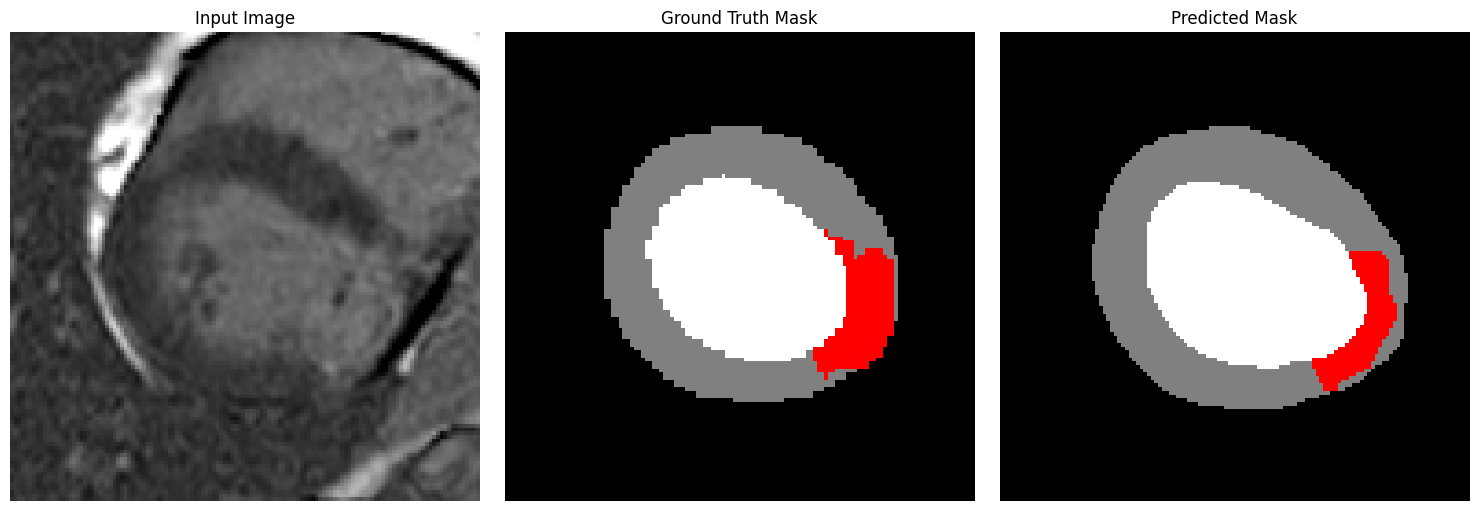

 91%|█████████▏| 73/80 [01:53<00:11,  1.65s/it]

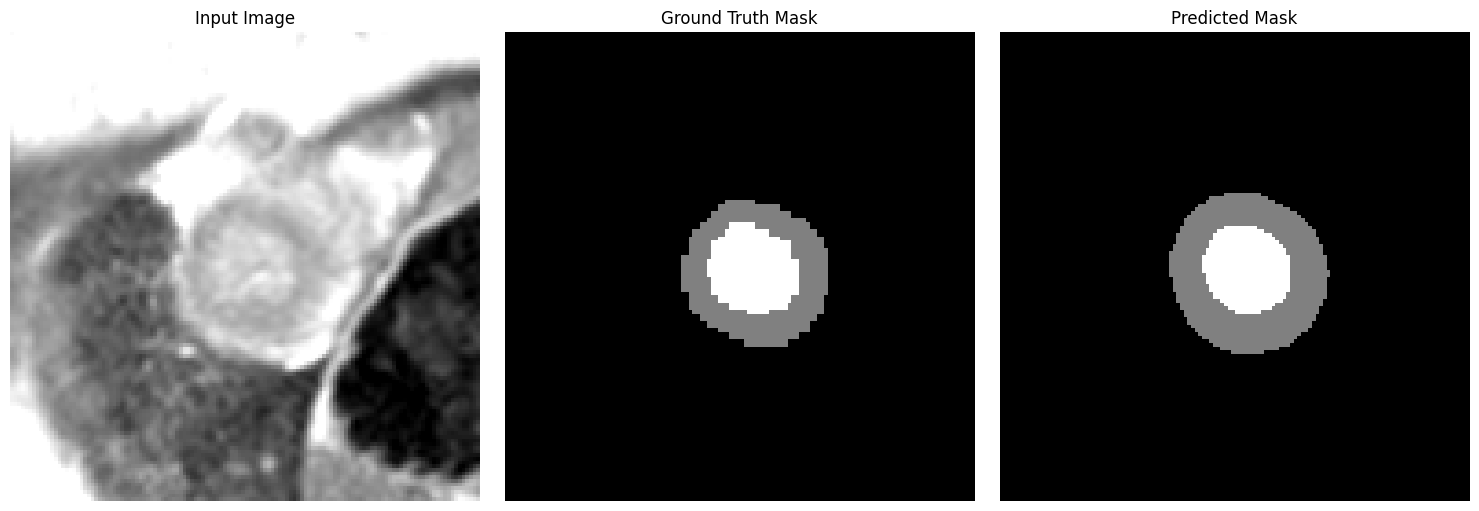

 92%|█████████▎| 74/80 [01:54<00:09,  1.54s/it]

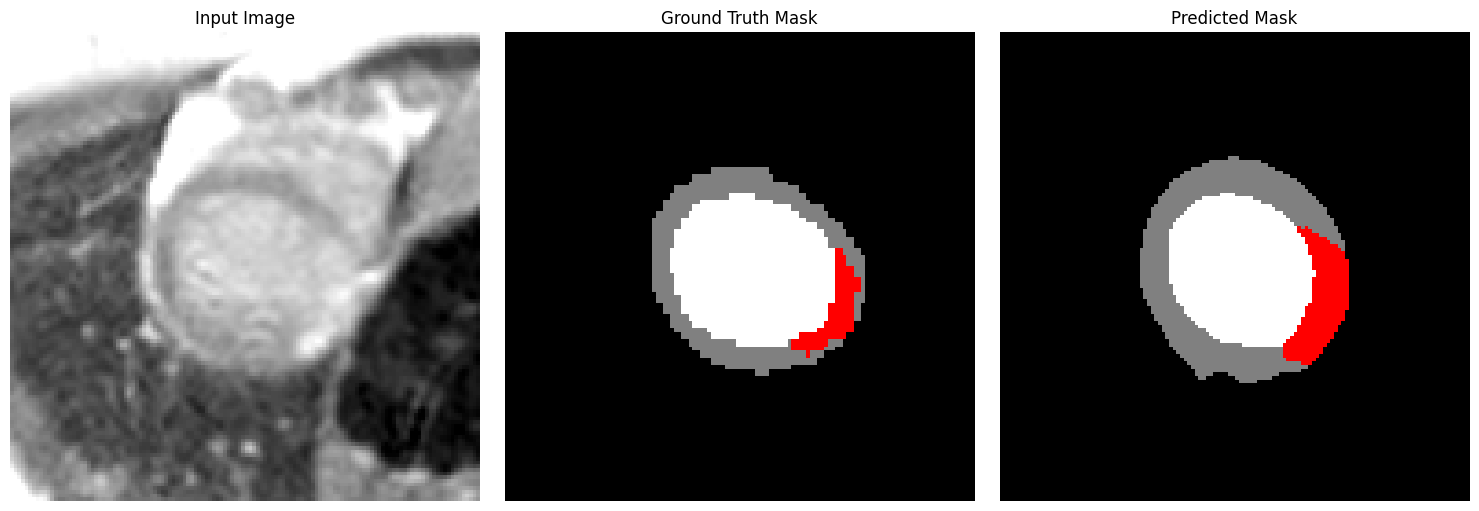

 94%|█████████▍| 75/80 [01:56<00:07,  1.49s/it]

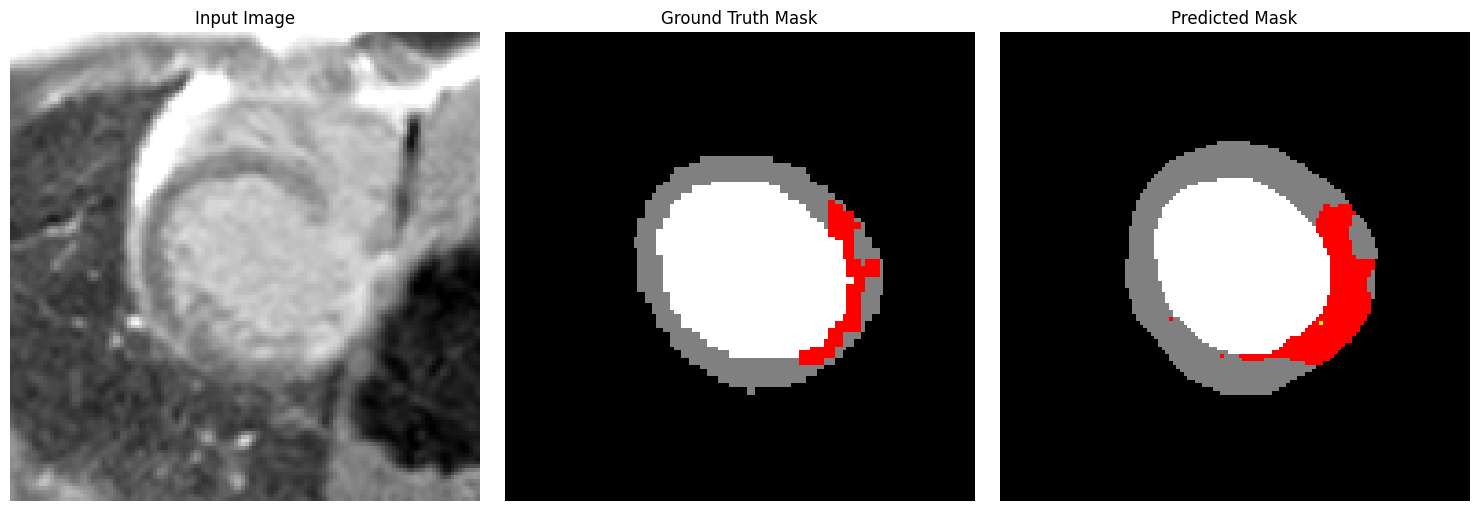

 95%|█████████▌| 76/80 [01:57<00:05,  1.45s/it]

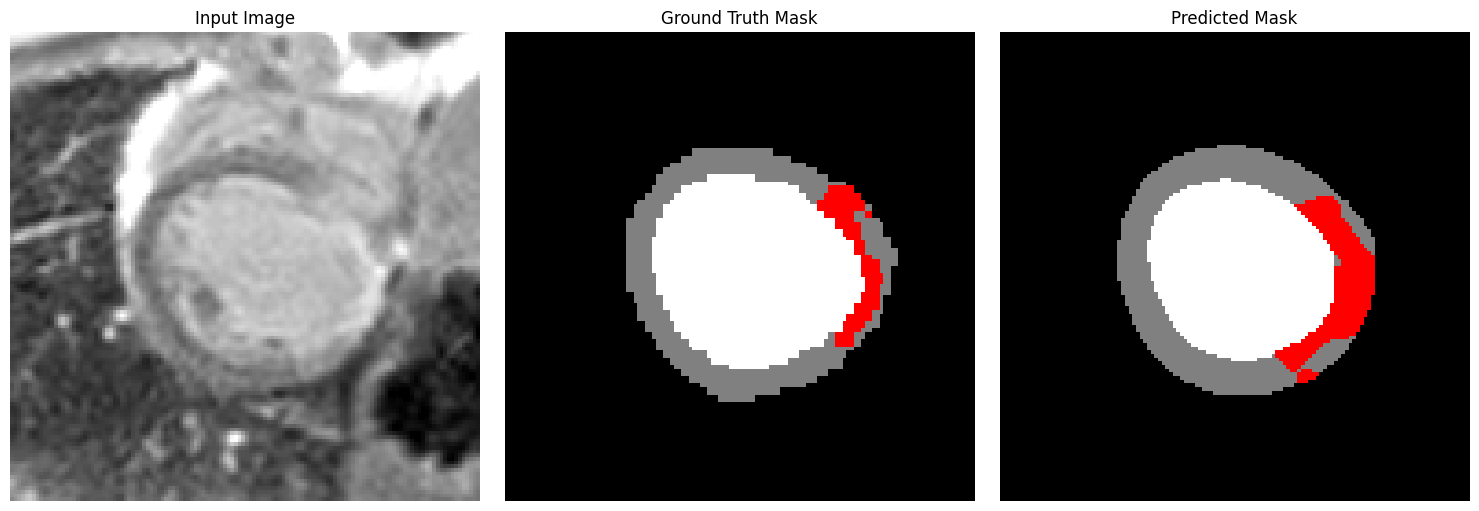

 96%|█████████▋| 77/80 [01:59<00:04,  1.45s/it]

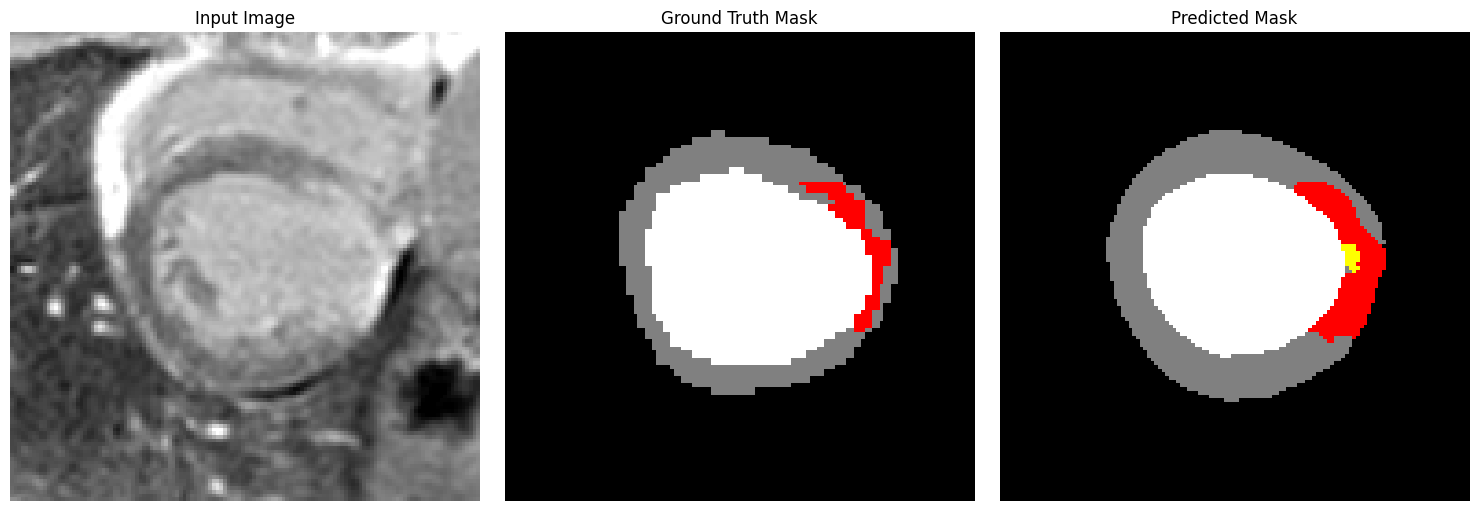

 98%|█████████▊| 78/80 [02:00<00:02,  1.45s/it]

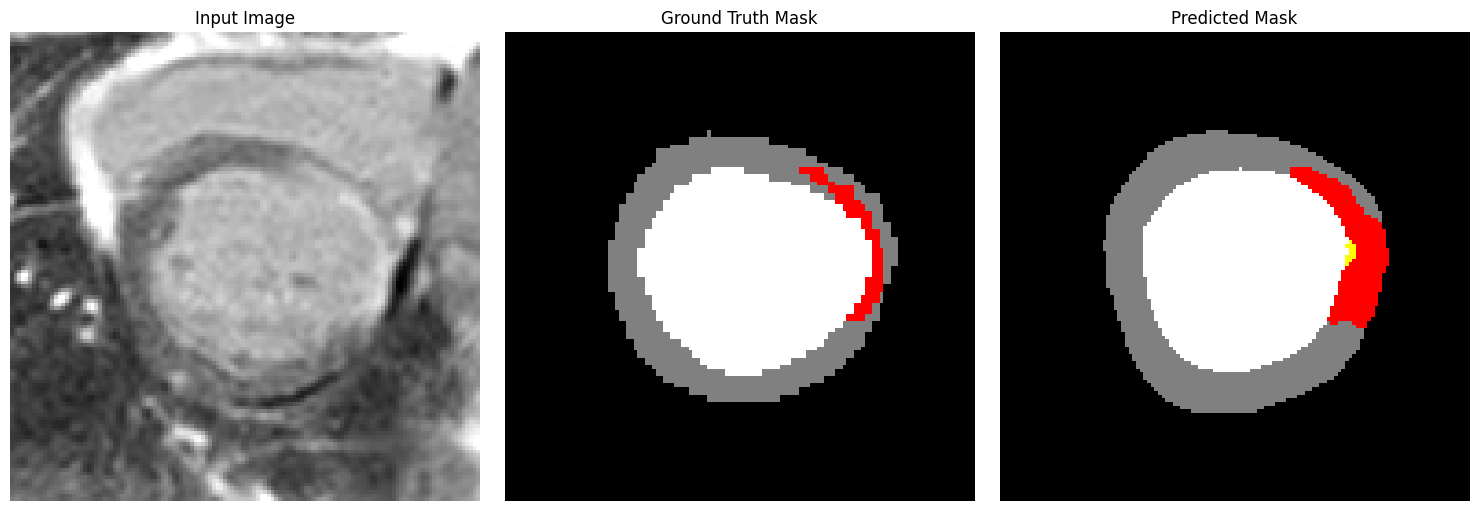

 99%|█████████▉| 79/80 [02:02<00:01,  1.47s/it]

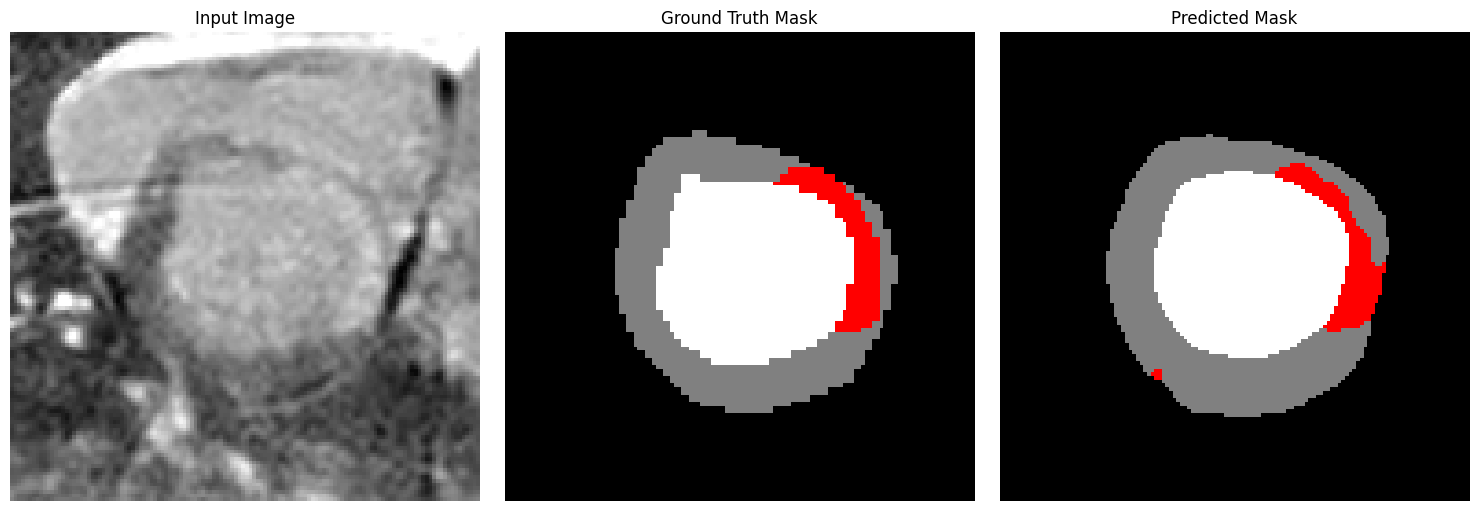

100%|██████████| 80/80 [02:04<00:00,  1.55s/it]


In [ ]:
from tqdm import tqdm  # optional for progress bar

# Loop through the test set
for i in tqdm(range(len(test_images_tensor))):  # tqdm adds a progress bar
    test_img = test_images_tensor[i]
    gt_mask = test_masks_tensor[i]

    # If tensors, convert to numpy
    if isinstance(test_img, tf.Tensor):
        test_img = test_img.numpy()
    if isinstance(gt_mask, tf.Tensor):
        gt_mask = gt_mask.numpy()

    # Add batch dimension
    test_img_expanded = np.expand_dims(test_img, axis=0)
    gt_mask_expanded = np.expand_dims(gt_mask, axis=0)

    # Call your function
    generate_images(model, test_img_expanded, gt_mask_expanded)
